# Import Modules

In [36]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
from collections import defaultdict
from pprint import pprint
import random
import pickle
from functools import reduce

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Add project directory to sys.path
# pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))
# sys.path.insert(1, pdir)
# from myutils import *

# Other module imports
import ast, math, swifter, csv, json, itertools as it, portion as P

# Set plot style
# plt.style.use('ggplot')

In [37]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

In [38]:
# ************************************************* Sheng-Ru Latest Version (09-25) add try except (10-27) add nr arfcn (11-13) add BSID (11-21) *************************************************

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ************************************************* parse into readable dataframe *************************************************

def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1['m_src'].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1['m_src'].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2['m_src'].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

In [39]:
def seconds_to_minutes_seconds_milliseconds(duration_in_seconds):
    # Convert to a timedelta object
    duration_timedelta = dt.timedelta(seconds=duration_in_seconds)

    # Extract minutes, seconds, and milliseconds
    minutes, seconds = divmod(duration_timedelta.seconds, 60)
    milliseconds = duration_timedelta.microseconds // 1000

    # Format the result
    formatted_time = "{:02}:{:02}.{:03}".format(minutes, seconds, milliseconds)

    return(formatted_time)

In [40]:
import os
import json

# Specify root directory
root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"

# Collect dates
dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s != 'backup']
date_dirs = [os.path.join(root_dir, s) for s in dates]

for date, date_dir in zip(dates, date_dirs):
    # Specify the path to your JSON file
    date = os.path.basename(date_dir)
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict:
        continue
        
    print(date, len(my_dict))
    
    for exp, item in my_dict.items():
        print({exp: item})

2023-03-16 1
{'UDP_Bandlock_B1_B7_B8_RM500Q': {'route': 'BR', 'devices': {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '19:23', ''], [2, '動物園', '萬芳醫院', '19:32', ''], [3, '萬芳醫院', '動物園', '19:39', ''], [4, '動物園', '萬芳醫院', '19:47', ''], [5, '萬芳醫院', '動物園', '19:55', ''], [6, '動物園', '萬芳醫院', '20:03', ''], [7, '萬芳醫院', '動物園', '20:09', ''], [8, '動物園', '萬芳醫院', '20:18', ''], [9, '萬芳醫院', '動物園', '20:27', ''], [10, '動物園', '萬芳醫院', '20:33', ''], [11, '萬芳醫院', '動物園', '20:42', ''], [12, '動物園', '萬芳醫院', '20:49', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-03-26 1
{'UDP_Bandlock_All_RM500Q': {'route': 'BR', 'devices': {'qc00': 'All', 'qc02': 'All', 'qc03': 'All'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '16:36', ''], [2, '動物園', '萬芳醫院', '16:46', ''

# Brown Line

## Select Data

In [41]:
# Select Dates
# sel_dates = dates[:]
# sel_dates = [s for s in dates if s >= '2023-09-12']
# sel_dates = [s for s in dates if s < '2023-09-12']
# sel_dates = [s for s in dates if s >= '2023-08-16' and s < '2023-09-12']
# sel_dates = dates[:5]
# sel_dates = dates[-8:]
sel_dates = ['2023-11-09']
exc_dates = []
# exc_dates = ['2023-06-12', '2023-06-13']
date_dirs = [os.path.join(root_dir, s) for s in sel_dates if s not in exc_dates]

# Select Experiment Names
sel_exps = []
# sel_exps = ['UDP_Bandlock_9S_Phone_Brown', 'UDP_Bandlock_9S_Phone_Airport']
# exc_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']

# Select Routes
# sel_routes = []
sel_routes = ['BR']

In [42]:
# Collect Experiments
exps_dict = {}

for date_dir in date_dirs:
    date = os.path.basename(date_dir)
    
    # Specify the path to your JSON file
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict:
        continue
    
    for i, (exp, item) in enumerate(my_dict.items()):
        if len(sel_exps) != 0 and exp not in sel_exps:
            continue
        
        if len(exc_exps) != 0 and exp in exc_exps:
            continue
        
        if len(sel_routes) != 0 and item['route'] not in sel_routes:
            continue
        
        try:
            exps_dict[date] = {**exps_dict[date], **{exp: item}}
        except:
            exps_dict[date] = {exp: item}

for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        print({exp_name: exp})

2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}


In [43]:
for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        for trip in trips:
            for dev in devices:
                data_dir = os.path.join(exp_dir, dev, trip, 'data')
                output_filepath = os.path.join(data_dir, 'experiment_duration.csv')
                
                print(output_filepath, os.path.isfile(output_filepath))
                # os.system(f'rm {output_filepath}')
                if os.path.isfile(output_filepath):
                    continue
                
                try:
                    dl_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('udp_dnlk_loss_latency_ho.pkl')][0]
                    # print(dl_filepath, os.path.isfile(dl_filepath))
                    dl_df = pd.read_pickle(dl_filepath)
                except:
                    dl_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('udp_dnlk_loss_latency.csv')][0]
                    # print(dl_filepath, os.path.isfile(dl_filepath))
                    dl_df = set_data(pd.read_csv(dl_filepath))
                    
                try:
                    ul_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('udp_uplk_loss_latency_ho.pkl')][0]
                    # print(ul_filepath, os.path.isfile(ul_filepath))
                    ul_df = pd.read_pickle(ul_filepath)
                except:
                    ul_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('udp_uplk_loss_latency.csv')][0]
                    # print(ul_filepath, os.path.isfile(ul_filepath))
                    ul_df = set_data(pd.read_csv(ul_filepath))
                
                start_ts = min([dl_df['Timestamp'].iloc[0], ul_df['Timestamp'].iloc[0]])
                end_ts = max([dl_df['Timestamp'].iloc[-1], ul_df['Timestamp'].iloc[-1]])
                exp_duration = round((end_ts - start_ts).total_seconds() / 60, 2)  # (minutes)
                
                rrc_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('rrc.csv')][0]
                # print(rrc_filepath, os.path.isfile(rrc_filepath))
                rrc_df = pd.read_csv(rrc_filepath, parse_dates=['Timestamp'], low_memory=False)
                rrc_df["Timestamp"] = rrc_df["Timestamp"].swifter.apply(lambda x: x + dt.timedelta(hours=8))
                rrc_df = rrc_df[(rrc_df['Timestamp'] >= start_ts) & (rrc_df['Timestamp'] < end_ts)].reset_index(drop=True)
                if not rrc_df.empty:
                    rrc_start_ts = rrc_df['Timestamp'].iloc[0] - pd.Timedelta(seconds=1)
                    rrc_end_ts = rrc_df['Timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
                    rrc_duration = round((rrc_end_ts - rrc_start_ts).total_seconds() / 60, 2)  # (minutes)
                else:
                    rrc_start_ts = pd.NA
                    rrc_end_ts = pd.NA
                    rrc_duration = 0.00
                
                fieldnames=['No.', 'Start', 'End', 'Duration']
                data = [
                    {'No.': 'total', 'Start': start_ts, 'End': end_ts, 'Duration': exp_duration},
                    {'No.': 'valid', 'Start': rrc_start_ts, 'End': rrc_end_ts, 'Duration': rrc_duration},
                ]
                
                with open(output_filepath, 'w', newline='') as csvfile:
                    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    csv_writer.writeheader()
                    csv_writer.writerows(data)

2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/experiment_duration.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/experiment_duration.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/experiment_dura

In [44]:
for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        print({exp_name: exp})
        
        # Check data abnormality
        exp_duration_check_path = os.path.join(exp_dir, 'exp_duration_minutes_check.csv')
        rrc_duration_check_path = os.path.join(exp_dir, 'rrc_duration_minutes_check.csv')
        nr_duration_check_path = os.path.join(exp_dir, 'nr_duration_minutes_check.csv')
        nr_alive_check_path = os.path.join(exp_dir, 'nr_alive_check.csv')
        
        # print(exp_duration_check_path, os.path.isfile(exp_duration_check_path))
        # print(rrc_duration_check_path, os.path.isfile(rrc_duration_check_path))
        # print(nr_alive_check_path, os.path.isfile(nr_alive_check_path))
        # print(nr_duration_check_path, os.path.isfile(nr_duration_check_path))
        
        # os.system(f'rm {exp_duration_check_path}')
        # os.system(f'rm {rrc_duration_check_path}')
        # os.system(f'rm {nr_alive_check_path}')
        # os.system(f'rm {nr_duration_check_path}')
        
        if os.path.isfile(exp_duration_check_path) and os.path.isfile(rrc_duration_check_path) and os.path.isfile(nr_duration_check_path) and os.path.isfile(nr_alive_check_path):
            exp_duration_table = pd.read_csv(exp_duration_check_path)
            rrc_duration_table = pd.read_csv(rrc_duration_check_path)
            nr_duration_table = pd.read_csv(nr_duration_check_path)
            nr_alive_table = pd.read_csv(nr_alive_check_path)
        else:
            devices = list(exp['devices'].keys())
            trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
            
            exp_duration_table = pd.DataFrame(columns=['Tr.', *devices])
            rrc_duration_table = pd.DataFrame(columns=['Tr.', *devices])
            nr_duration_table = pd.DataFrame(columns=['Tr.', *devices])
            nr_alive_table = pd.DataFrame(columns=['Tr.', *devices])

            for trip in trips:
                exp_duration_list = [trip] + [0.00] * len(devices)
                rrc_duration_list = [trip] + [0.00] * len(devices)
                nr_duration_list = [trip] + [0.00] * len(devices)
                nr_alive_list = [trip] + ['O'] * len(devices)
                
                for j, dev in enumerate(devices):
                    data_dir = os.path.join(exp_dir, dev, trip, 'data')
                    dur_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('experiment_duration.csv')][0]
                    rrc_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('rrc.csv')][0]
                    nr_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('nr_ml1.csv')][0]
                    
                    # print(dur_filepath, os.path.isfile(dur_filepath))
                    # print(rrc_filepath, os.path.isfile(rrc_filepath))
                    # print(nr_filepath, os.path.isfile(nr_filepath))
                    
                    dur_df = pd.read_csv(dur_filepath, parse_dates=['Start', 'End'])
                    start_ts = dur_df['Start'].iloc[0] - pd.Timedelta(hours=8)
                    end_ts = dur_df['End'].iloc[0] - pd.Timedelta(hours=8)
                    exp_duration_list[j+1] = dur_df['Duration'].iloc[0]
                    
                    rrc_df = pd.read_csv(rrc_filepath, parse_dates=['Timestamp'], low_memory=False)
                    rrc_df = rrc_df[(rrc_df['Timestamp'] >= start_ts) & (rrc_df['Timestamp'] < end_ts)].reset_index(drop=True)
                    if not rrc_df.empty:
                        rrc_start_ts = rrc_df['Timestamp'].iloc[0]
                        rrc_end_ts = rrc_df['Timestamp'].iloc[-1]
                        rrc_duration_list[j+1] = round((rrc_end_ts - rrc_start_ts).total_seconds() / 60, 2)  # (minutes)
                    
                    if rrc_df.empty:
                        nr_alive_list[j+1] = '-'
                    elif sum(np.in1d(rrc_df['failureType-r15'], 'rlc-MaxNumRetx (2)')) > 0:
                        nr_alive_list[j+1] = '∆'
                    
                    nr_df = pd.read_csv(nr_filepath, parse_dates=['Timestamp'])
                    nr_df = nr_df[(nr_df['Timestamp'] >= start_ts) & (nr_df['Timestamp'] < end_ts)].reset_index(drop=True)
                    if rrc_df.empty and nr_df.empty:
                        nr_alive_list[j+1] = '-'
                    elif nr_df.empty:
                        nr_alive_list[j+1] = 'X'
                    
                    if not nr_df.empty:
                        nr_start_ts = nr_df['Timestamp'].iloc[0]
                        nr_end_ts = nr_df['Timestamp'].iloc[-1]
                        nr_duration_list[j+1] = round((nr_end_ts - nr_start_ts).total_seconds() / 60, 2)  # (minutes)
                
                exp_duration_table.loc[len(exp_duration_table)] = exp_duration_list
                rrc_duration_table.loc[len(rrc_duration_table)] = rrc_duration_list
                nr_duration_table.loc[len(nr_duration_table)] = nr_duration_list
                nr_alive_table.loc[len(nr_alive_table)] = nr_alive_list
            
            exp_duration_table.to_csv(exp_duration_check_path, index=False)
            rrc_duration_table.to_csv(rrc_duration_check_path, index=False)
            nr_duration_table.to_csv(nr_duration_check_path, index=False)
            nr_alive_table.to_csv(nr_alive_check_path, index=False)
        
        print('exp_duration_table (minutes)')
        display(exp_duration_table)
        print('rrc_duration_table (minutes)')
        display(rrc_duration_table)
        print('nr_duration_table (minutes)')
        display(nr_duration_table)
        print('nr_alive_table')
        display(nr_alive_table)

print('O: RF Module is always on.')
print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
print('-: RRC File is EMPTY!!!')

2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
exp_duration_table (minutes)


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,46.18,46.19,46.19,46.18,46.18,46.18,46.18,46.18,46.19
1,#02,47.77,47.76,47.76,47.76,47.76,47.75,47.75,47.76,47.75


rrc_duration_table (minutes)


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,46.10,46.16,46.08,46.12,45.99,46.17,46.12,45.96,46.10
1,#02,47.71,47.74,47.70,47.51,47.68,47.68,47.53,47.66,47.72


nr_duration_table (minutes)


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,46.18,20.84,22.45,46.18,46.18,22.90,46.18,46.03,0.0
1,#02,47.76,39.33,47.75,47.76,47.75,47.75,47.59,47.76,0.0


nr_alive_table


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,∆,∆,∆,∆,∆,∆,∆,O,X
1,#02,∆,∆,O,∆,∆,∆,∆,∆,X


O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.
-: RRC File is EMPTY!!!


## Single Radio: Handover Analysis (Downlink)

In [45]:
filepaths = []

for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        
        # print(devices)
        
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        
        for trip in trips:
            for dev in devices:
                data_dir = os.path.join(exp_dir, dev, trip, 'data')
                # print(data_dir, os.path.isdir(data_dir))
                
                dur_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('experiment_duration.csv')][0]
                ho_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('handover_info_log.csv')][0]
                dl_filepath = os.path.join(data_dir, 'udp_dnlk_loss_latency_ho.pkl')
                ul_filepath = os.path.join(data_dir, 'udp_uplk_loss_latency_ho.pkl')
                
                # print(dur_filepath, os.path.isfile(dur_filepath))
                # print(ho_filepath, os.path.isfile(ho_filepath))
                # print(dl_filepath, os.path.isfile(dl_filepath))
                # print(ul_filepath, os.path.isfile(ul_filepath)
                
                ho_df = pd.read_csv(ho_filepath)
                
                if ho_df.empty:
                    continue
                
                filepaths.append((dur_filepath, ho_filepath, dl_filepath, ul_filepath))

pprint(filepaths, sort_dicts=False)
print(len(filepaths))

2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/experiment_duration.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_

In [46]:
selected_cols = ['seq', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time',
                 'stage', 'category', 'type', 'cause', 'index', 'inter-RAT', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng']

ho_types = [
    'NASR', 'MCGF', 'SCGF',
    'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM',
    'stable',
]

nasr_causes = ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']
mcgf_causes = ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']
scgf_causes = ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 
               'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']

sr_stats_table_list = []
for dur_filepath, ho_filepath, dl_filepath, ul_filepath in filepaths:
    tables = []
    metrics = []
    
    ########### in for loop (iterating exprs) ##### start
    dur_df = pd.read_csv(dur_filepath, parse_dates=['Start', 'End'])
    df = pd.read_pickle(dl_filepath)[selected_cols]
    
    start_ts, end_ts = dur_df['Start'].iloc[1], dur_df['End'].iloc[1]
    df = df[(df['arr_time'] >= start_ts) & (df['arr_time'] < end_ts)]
    # display(df)
    
    exp_duration = dur_df['Duration'].iloc[1]
    # print(exp_duration)
    
    df['loex'] = df['excl'].copy()
    df['excl'] = ~df['lost'] & df['loex']
    df['total_sent'] = True
    
    # 13 Types
    df['type'] = df['type'].astype('category').cat.set_categories(ho_types)
    df['stage'] = df['stage'].astype('category').cat.set_categories(['-', 'before', 'during', 'after'])
    table = df.groupby(['type', 'stage']) \
        [['lost', 'excl', 'loex', 'total_sent']].sum()
    
    for mets in ['lost', 'excl', 'loex']:
        metrics.append(table[mets].sum())
        
    # Event Counts
    table1 = df[['type', 'stage', 'index']].value_counts().reset_index()
    table1 = table1[['type', 'stage']].value_counts().to_frame().rename(columns={0: 'count'})
    table = table.merge(table1, on=['type', 'stage'], how='outer')
    table['count'] = table['count'].fillna(0).astype(int)
    
    # Calculate Overlapping Duration
    table1 = df[~df.duplicated(subset=['type', 'stage', 'index'], keep='first')][['type', 'stage', 'index', 'seq', 'arr_time']]
    table2 = df[~df.duplicated(subset=['type', 'stage', 'index'], keep='last')][['type', 'stage', 'index', 'seq', 'arr_time']]
    
    table1 = pd.concat([table1, table2], ignore_index=True).sort_values(by='seq').reset_index(drop=True)
    table3 = pd.DataFrame()
    for ho_type in ho_types:
        if ho_type == 'stable':
            continue
        for stage in ['-', 'before', 'during', 'after']:
            table2 = table1[(table1['type'] == ho_type) & (table1['stage'] == stage)].reset_index(drop=True).copy()
            table2['next_arr_time'] = table2['arr_time'].shift(-1)
            table2 = table2.iloc[::2]
            table2['total_impact_duration (sec)'] = (table2['next_arr_time'] - table2['arr_time']).dt.total_seconds()

            table3 = pd.concat([table3, table2], ignore_index=True)
    
    table3 = table3.groupby(['type', 'stage'])[['total_impact_duration (sec)']].sum()
    table3.at[('stable', '-'), 'total_impact_duration (sec)'] = exp_duration * 60 - table3['total_impact_duration (sec)'].sum()
    table = table.merge(table3, on=['type', 'stage'], how='outer')
    
    for ho_type in ho_types:
        selected_rows = table.loc[table.index.get_level_values(0) == ho_type].copy()
        table.at[(ho_type, '-')] = selected_rows.sum()
        table.loc[table.index.get_level_values(0) == ho_type, 'count'] = selected_rows['count'].max()
    
    # Overall Metrics
    table['exp_duration (min)'] = exp_duration
    for i, mets in enumerate(['lost', 'excl', 'loex']):
        table[f'total_{mets}'] = metrics[i]
    
    tables.append(table)
    # display(table)
    
    # RLF Causes
    for rlf_type, rlf_causes in zip(['NASR', 'MCGF', 'SCGF'], [nasr_causes, mcgf_causes, scgf_causes]):
        df1 = df[df['type'] == rlf_type].copy()
        # display(df1)
        df1['type'] = df1['type'].astype('category').cat.set_categories([rlf_type])
        df1['cause'] = df1['cause'].astype('category').cat.set_categories(['-', *rlf_causes])
        df1['stage'] = df1['stage'].astype('category').cat.set_categories(['-', 'before', 'during', 'after'])
        table = df1.groupby(['type', 'cause', 'stage']) \
            [['lost', 'excl', 'loex', 'total_sent']].sum()
        
        # Event Counts
        table1 = df1[['type', 'cause', 'stage', 'index']].value_counts().reset_index()
        table1 = table1[['type', 'cause', 'stage']].value_counts().to_frame().rename(columns={0: 'count'})
        table = table.merge(table1, on=['type', 'cause', 'stage'], how='outer')
        table['count'] = table['count'].fillna(0).astype(int)
        
        # Calculate Overlapping Duration
        table1 = df1[~df1.duplicated(subset=['type', 'cause', 'stage', 'index'], keep='first')][['type', 'cause', 'stage', 'index', 'seq', 'arr_time']]
        table2 = df1[~df1.duplicated(subset=['type', 'cause', 'stage', 'index'], keep='last')][['type', 'cause', 'stage', 'index', 'seq', 'arr_time']]
        
        table1 = pd.concat([table1, table2], ignore_index=True).sort_values(by='seq').reset_index(drop=True)
        table3 = pd.DataFrame()
        for rlf_cause in rlf_causes:
            for stage in ['-', 'before', 'during', 'after']:
                table2 = table1[(table1['cause'] == rlf_cause) & (table1['stage'] == stage)].reset_index(drop=True).copy()
                table2['next_arr_time'] = table2['arr_time'].shift(-1)
                table2 = table2.iloc[::2]
                table2['total_impact_duration (sec)'] = (table2['next_arr_time'] - table2['arr_time']).dt.total_seconds()
                
                table3 = pd.concat([table3, table2], ignore_index=True)
        
        table3 = table3.groupby(['type', 'cause', 'stage'])[['total_impact_duration (sec)']].sum()
        table = table.merge(table3, on=['type', 'cause', 'stage'], how='outer')
        
        for rlf_cause in rlf_causes:
            selected_rows = table.loc[table.index.get_level_values(1) == rlf_cause].copy()
            table.loc[(rlf_type, rlf_cause, '-')] = selected_rows.sum()
            table.loc[table.index.get_level_values(1) == rlf_cause, 'count'] = selected_rows['count'].max()
        
        # Overall Metrics
        table['exp_duration (min)'] = exp_duration
        for i, mets in enumerate(['lost', 'excl', 'loex']):
            table[f'total_{mets}'] = metrics[i]
        
        for stage in ['-', 'before', 'during', 'after']:
            selected_rows = tables[0].loc[(rlf_type, stage)].copy()
            table.loc[(rlf_type, '-', stage)] = selected_rows
        
        tables.append(table)
        # display(table)
    
    sr_stats_table_list.append(tables)
    # for table in tables:
    #     display(table)
    #     # display(table[table['count'] != 0].reset_index())
    del table, tables
    
    # # complete table
    # display(table.reset_index())
    # # complete dictionary
    # pprint(table.to_dict(orient='index'), sort_dicts=False)
    # # recover the complete table from dictionary
    # display(pd.DataFrame(table.to_dict(orient='index')).T.rename_axis(['type_x', 'type_y']).reset_index())
        
    # # table without all-zero rows
    # display(table[(table != 0).any(axis=1)].reset_index())
    # # dictionary without all-zero rows
    # pprint(table[(table != 0).any(axis=1)].to_dict(orient='index'), sort_dicts=False)
    # # recover the table without all-zero rows from dictionary
    # display(pd.DataFrame(table[(table != 0).any(axis=1)].to_dict(orient='index')).T.rename_axis(['type_x', 'type_y']).reset_index())
    
    # break
    ########### in for loop (iterating exprs) ##### end

### Merge

In [47]:
cnt_tables = []
for i in range(4):
    # merge
    cnt_table = reduce(lambda x, y: x.add(y, fill_value=0), [item[i] for item in sr_stats_table_list])
    
    # 选择所有分子列
    molecule_cols = cnt_table.columns[:cnt_table.columns.get_loc('total_sent')]
    
    # 百分比
    df_percentage = (cnt_table[molecule_cols].div(cnt_table['total_sent'], axis=0) * 100).round(3)
    df_percentage.columns = [f'{col}_r (%)' for col in molecule_cols]
    
    # per event
    df_per_event = cnt_table[molecule_cols].div(cnt_table['count'], axis=0).round(2)
    df_per_event.columns = [f'{col}_pe' for col in molecule_cols]
    
    # lost proportion
    for mets in ['lost', 'excl', 'loex']:
        cnt_table[f'{mets}_prop (%)'] = (cnt_table[f'{mets}'].div(cnt_table[f'total_{mets}'], axis=0) * 100).round(3)
    
    # HO Frequency, Ave Overlapping Duration
    cnt_table['Count'] = cnt_table['count'].copy()
    cnt_table['Frequency (/hr)'] = (cnt_table['count'].div(cnt_table['exp_duration (min)'], axis=0) * 60).round(2)
    cnt_table['Average Impact Duration (sec)'] = (cnt_table['total_impact_duration (sec)'].div(cnt_table['count'], axis=0)).round(3).fillna(0)
    if i == 0:
        selected_rows = cnt_table.loc[cnt_table.index.get_level_values(1) == '-']
        normalized_factor = 3600 / (selected_rows['Frequency (/hr)'] * selected_rows['Average Impact Duration (sec)']).sum()
    cnt_table['Average Impact Duration (sec)'] = (cnt_table['Average Impact Duration (sec)'] * normalized_factor).round(3)
    cnt_table['Total Impact Duration (sec)'] = cnt_table['total_impact_duration (sec)'].copy().round(3)
    cnt_table['Total Impact Duration (%)'] = (cnt_table['total_impact_duration (sec)'].div(cnt_table['exp_duration (min)'], axis=0) / 60 * 100).round(3)
    
    # 合併表格
    cnt_table = pd.concat([cnt_table, df_percentage, df_per_event], axis=1)
    cnt_table = cnt_table[['Count', 'Frequency (/hr)', 'Average Impact Duration (sec)', 'Total Impact Duration (sec)', 'Total Impact Duration (%)',
                           'lost', 'excl', 'loex',
                           'lost_r (%)', 'excl_r (%)', 'loex_r (%)',
                           'lost_pe', 'excl_pe', 'loex_pe',
                           'lost_prop (%)', 'excl_prop (%)', 'loex_prop (%)',
                           'total_sent', 'exp_duration (min)']]
    cnt_tables.append(cnt_table)
    # break

# for i in range(4):
#     display(cnt_tables[i])
#     # break

### Save SR Table

In [48]:
sr_table_dl = cnt_tables[0].copy()
sr_nasr_table_dl = cnt_tables[1].copy()
sr_mcgf_table_dl = cnt_tables[2].copy()
sr_scgf_table_dl = cnt_tables[3].copy()

# del cnt_tables, sr_stats_table_list

## Single Radio: Handover Analysis (Uplink)

In [49]:
filepaths = []

for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        
        # print(devices)
        
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        
        for trip in trips:
            for dev in devices:
                data_dir = os.path.join(exp_dir, dev, trip, 'data')
                # print(data_dir, os.path.isdir(data_dir))
                
                dur_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('experiment_duration.csv')][0]
                ho_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('handover_info_log.csv')][0]
                dl_filepath = os.path.join(data_dir, 'udp_dnlk_loss_latency_ho.pkl')
                ul_filepath = os.path.join(data_dir, 'udp_uplk_loss_latency_ho.pkl')
                
                # print(dur_filepath, os.path.isfile(dur_filepath))
                # print(ho_filepath, os.path.isfile(ho_filepath))
                # print(dl_filepath, os.path.isfile(dl_filepath))
                # print(ul_filepath, os.path.isfile(ul_filepath)
                
                ho_df = pd.read_csv(ho_filepath)
                
                if ho_df.empty:
                    continue
                
                filepaths.append((dur_filepath, ho_filepath, dl_filepath, ul_filepath))

pprint(filepaths, sort_dicts=False)

2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/experiment_duration.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_

In [50]:
selected_cols = ['seq', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time',
                 'stage', 'category', 'type', 'cause', 'index', 'inter-RAT', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng']

ho_types = [
    'NASR', 'MCGF', 'SCGF',
    'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM',
    'stable',
]

nasr_causes = ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']
mcgf_causes = ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']
scgf_causes = ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 
               'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']

sr_stats_table_list = []
for dur_filepath, ho_filepath, dl_filepath, ul_filepath in filepaths:
    tables = []
    metrics = []
    
    ########### in for loop (iterating exprs) ##### start
    dur_df = pd.read_csv(dur_filepath, parse_dates=['Start', 'End'])
    df = pd.read_pickle(ul_filepath)[selected_cols]
    
    start_ts, end_ts = dur_df['Start'].iloc[1], dur_df['End'].iloc[1]
    df = df[(df['xmit_time'] >= start_ts) & (df['xmit_time'] < end_ts)]
    # display(df)
    
    exp_duration = dur_df['Duration'].iloc[1]
    # print(exp_duration)
    
    df['loex'] = df['excl'].copy()
    df['excl'] = ~df['lost'] & df['loex']
    df['total_sent'] = True
    
    # 13 Types
    df['type'] = df['type'].astype('category').cat.set_categories(ho_types)
    df['stage'] = df['stage'].astype('category').cat.set_categories(['-', 'before', 'during', 'after'])
    table = df.groupby(['type', 'stage']) \
        [['lost', 'excl', 'loex', 'total_sent']].sum()
    
    for mets in ['lost', 'excl', 'loex']:
        metrics.append(table[mets].sum())
        
    # Event Counts
    table1 = df[['type', 'stage', 'index']].value_counts().reset_index()
    table1 = table1[['type', 'stage']].value_counts().to_frame().rename(columns={0: 'count'})
    table = table.merge(table1, on=['type', 'stage'], how='outer')
    table['count'] = table['count'].fillna(0).astype(int)
    
    # Calculate Overlapping Duration
    table1 = df[~df.duplicated(subset=['type', 'stage', 'index'], keep='first')][['type', 'stage', 'index', 'seq', 'xmit_time']]
    table2 = df[~df.duplicated(subset=['type', 'stage', 'index'], keep='last')][['type', 'stage', 'index', 'seq', 'xmit_time']]
    
    table1 = pd.concat([table1, table2], ignore_index=True).sort_values(by='seq').reset_index(drop=True)
    table3 = pd.DataFrame()
    for ho_type in ho_types:
        if ho_type == 'stable':
            continue
        for stage in ['-', 'before', 'during', 'after']:
            table2 = table1[(table1['type'] == ho_type) & (table1['stage'] == stage)].reset_index(drop=True).copy()
            table2['next_xmit_time'] = table2['xmit_time'].shift(-1)
            table2 = table2.iloc[::2]
            table2['total_impact_duration (sec)'] = (table2['next_xmit_time'] - table2['xmit_time']).dt.total_seconds()

            table3 = pd.concat([table3, table2], ignore_index=True)
    
    table3 = table3.groupby(['type', 'stage'])[['total_impact_duration (sec)']].sum()
    table3.at[('stable', '-'), 'total_impact_duration (sec)'] = exp_duration * 60 - table3['total_impact_duration (sec)'].sum()
    table = table.merge(table3, on=['type', 'stage'], how='outer')
    
    for ho_type in ho_types:
        selected_rows = table.loc[table.index.get_level_values(0) == ho_type].copy()
        table.at[(ho_type, '-')] = selected_rows.sum()
        table.loc[table.index.get_level_values(0) == ho_type, 'count'] = selected_rows['count'].max()
    
    # Overall Metrics
    table['exp_duration (min)'] = exp_duration
    for i, mets in enumerate(['lost', 'excl', 'loex']):
        table[f'total_{mets}'] = metrics[i]
    
    tables.append(table)
    # display(table)
    
    # RLF Causes
    for rlf_type, rlf_causes in zip(['NASR', 'MCGF', 'SCGF'], [nasr_causes, mcgf_causes, scgf_causes]):
        df1 = df[df['type'] == rlf_type].copy()
        # display(df1)
        df1['type'] = df1['type'].astype('category').cat.set_categories([rlf_type])
        df1['cause'] = df1['cause'].astype('category').cat.set_categories(['-', *rlf_causes])
        df1['stage'] = df1['stage'].astype('category').cat.set_categories(['-', 'before', 'during', 'after'])
        table = df1.groupby(['type', 'cause', 'stage']) \
            [['lost', 'excl', 'loex', 'total_sent']].sum()
        
        # Event Counts
        table1 = df1[['type', 'cause', 'stage', 'index']].value_counts().reset_index()
        table1 = table1[['type', 'cause', 'stage']].value_counts().to_frame().rename(columns={0: 'count'})
        table = table.merge(table1, on=['type', 'cause', 'stage'], how='outer')
        table['count'] = table['count'].fillna(0).astype(int)
        
        # Calculate Overlapping Duration
        table1 = df1[~df1.duplicated(subset=['type', 'cause', 'stage', 'index'], keep='first')][['type', 'cause', 'stage', 'index', 'seq', 'xmit_time']]
        table2 = df1[~df1.duplicated(subset=['type', 'cause', 'stage', 'index'], keep='last')][['type', 'cause', 'stage', 'index', 'seq', 'xmit_time']]
        
        table1 = pd.concat([table1, table2], ignore_index=True).sort_values(by='seq').reset_index(drop=True)
        table3 = pd.DataFrame()
        for rlf_cause in rlf_causes:
            for stage in ['-', 'before', 'during', 'after']:
                table2 = table1[(table1['cause'] == rlf_cause) & (table1['stage'] == stage)].reset_index(drop=True).copy()
                table2['next_xmit_time'] = table2['xmit_time'].shift(-1)
                table2 = table2.iloc[::2]
                table2['total_impact_duration (sec)'] = (table2['next_xmit_time'] - table2['xmit_time']).dt.total_seconds()
                
                table3 = pd.concat([table3, table2], ignore_index=True)
        
        table3 = table3.groupby(['type', 'cause', 'stage'])[['total_impact_duration (sec)']].sum()
        table = table.merge(table3, on=['type', 'cause', 'stage'], how='outer')
        
        for rlf_cause in rlf_causes:
            selected_rows = table.loc[table.index.get_level_values(1) == rlf_cause].copy()
            table.loc[(rlf_type, rlf_cause, '-')] = selected_rows.sum()
            table.loc[table.index.get_level_values(1) == rlf_cause, 'count'] = selected_rows['count'].max()
        
        # Overall Metrics
        table['exp_duration (min)'] = exp_duration
        for i, mets in enumerate(['lost', 'excl', 'loex']):
            table[f'total_{mets}'] = metrics[i]
        
        for stage in ['-', 'before', 'during', 'after']:
            selected_rows = tables[0].loc[(rlf_type, stage)].copy()
            table.loc[(rlf_type, '-', stage)] = selected_rows
        
        tables.append(table)
        # display(table)
    
    sr_stats_table_list.append(tables)
    # for table in tables:
    #     display(table)
    #     # display(table[table['count'] != 0].reset_index())
    del table, tables
    
    # # complete table
    # display(table.reset_index())
    # # complete dictionary
    # pprint(table.to_dict(orient='index'), sort_dicts=False)
    # # recover the complete table from dictionary
    # display(pd.DataFrame(table.to_dict(orient='index')).T.rename_axis(['type_x', 'type_y']).reset_index())
        
    # # table without all-zero rows
    # display(table[(table != 0).any(axis=1)].reset_index())
    # # dictionary without all-zero rows
    # pprint(table[(table != 0).any(axis=1)].to_dict(orient='index'), sort_dicts=False)
    # # recover the table without all-zero rows from dictionary
    # display(pd.DataFrame(table[(table != 0).any(axis=1)].to_dict(orient='index')).T.rename_axis(['type_x', 'type_y']).reset_index())
    
    # break
    ########### in for loop (iterating exprs) ##### end

### Merge

In [51]:
cnt_tables = []
for i in range(4):
    # merge
    cnt_table = reduce(lambda x, y: x.add(y, fill_value=0), [item[i] for item in sr_stats_table_list])
    
    # 选择所有分子列
    molecule_cols = cnt_table.columns[:cnt_table.columns.get_loc('total_sent')]
    
    # 百分比
    df_percentage = (cnt_table[molecule_cols].div(cnt_table['total_sent'], axis=0) * 100).round(3)
    df_percentage.columns = [f'{col}_r (%)' for col in molecule_cols]
    
    # per event
    df_per_event = cnt_table[molecule_cols].div(cnt_table['count'], axis=0).round(2)
    df_per_event.columns = [f'{col}_pe' for col in molecule_cols]
    
    # lost proportion
    for mets in ['lost', 'excl', 'loex']:
        cnt_table[f'{mets}_prop (%)'] = (cnt_table[f'{mets}'].div(cnt_table[f'total_{mets}'], axis=0) * 100).round(3)
    
    # HO Frequency, Ave Overlapping Duration
    cnt_table['Count'] = cnt_table['count'].copy()
    cnt_table['Frequency (/hr)'] = (cnt_table['count'].div(cnt_table['exp_duration (min)'], axis=0) * 60).round(2)
    cnt_table['Average Impact Duration (sec)'] = (cnt_table['total_impact_duration (sec)'].div(cnt_table['count'], axis=0)).round(3).fillna(0)
    if i == 0:
        selected_rows = cnt_table.loc[cnt_table.index.get_level_values(1) == '-']
        normalized_factor = 3600 / (selected_rows['Frequency (/hr)'] * selected_rows['Average Impact Duration (sec)']).sum()
    cnt_table['Average Impact Duration (sec)'] = (cnt_table['Average Impact Duration (sec)'] * normalized_factor).round(3)
    cnt_table['Total Impact Duration (sec)'] = cnt_table['total_impact_duration (sec)'].copy().round(3)
    cnt_table['Total Impact Duration (%)'] = (cnt_table['total_impact_duration (sec)'].div(cnt_table['exp_duration (min)'], axis=0) / 60 * 100).round(3)
    
    # 合併表格
    cnt_table = pd.concat([cnt_table, df_percentage, df_per_event], axis=1)
    cnt_table = cnt_table[['Count', 'Frequency (/hr)', 'Average Impact Duration (sec)', 'Total Impact Duration (sec)', 'Total Impact Duration (%)',
                           'lost', 'excl', 'loex',
                           'lost_r (%)', 'excl_r (%)', 'loex_r (%)',
                           'lost_pe', 'excl_pe', 'loex_pe',
                           'lost_prop (%)', 'excl_prop (%)', 'loex_prop (%)',
                           'total_sent', 'exp_duration (min)']]
    cnt_tables.append(cnt_table)
    # break

# for i in range(4):
#     display(cnt_tables[i])
#     # break

### Save SR Table

In [52]:
sr_table_ul = cnt_tables[0].copy()
sr_nasr_table_ul = cnt_tables[1].copy()
sr_mcgf_table_ul = cnt_tables[2].copy()
sr_scgf_table_ul = cnt_tables[3].copy()

# del cnt_tables, sr_stats_table_list

## Dual Radio: Handover Analysis (Downlink)

In [53]:
filepaths = []

for date, exps in exps_dict.items():
    print(date, len(exps))
    
    for exp_name, exp in exps.items():
        exp_dir = os.path.join(root_dir, date, exp_name)
        print({exp_name: exp})
        
        devices = list(exp['devices'].keys())
        dev_combos = list(it.combinations(devices, 2))
        dev_perms = list(it.permutations(devices, 2))
        
        # print(dev_combos)
        # print(dev_perms)
        
        trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
        
        for trip in trips:
            for dev1, dev2 in dev_combos:
            # for dev1, dev2 in dev_perms:
                data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                # print(data_dir1, os.path.isdir(data_dir1))
                # print(data_dir2, os.path.isdir(data_dir2))
                
                dur_filepath1 = [os.path.join(data_dir1, s) for s in os.listdir(data_dir1) if s.startswith('experiment_duration.csv')][0]
                ho_filepath1 = [os.path.join(data_dir1, s) for s in os.listdir(data_dir1) if s.startswith('handover_info_log.csv')][0]
                dl_filepath1 = os.path.join(data_dir1, 'udp_dnlk_loss_latency_ho.pkl')
                ul_filepath1 = os.path.join(data_dir1, 'udp_uplk_loss_latency_ho.pkl')
                dur_filepath2 = [os.path.join(data_dir2, s) for s in os.listdir(data_dir2) if s.startswith('experiment_duration.csv')][0]
                ho_filepath2 = [os.path.join(data_dir2, s) for s in os.listdir(data_dir2) if s.startswith('handover_info_log.csv')][0]
                dl_filepath2 = os.path.join(data_dir2, 'udp_dnlk_loss_latency_ho.pkl')
                ul_filepath2 = os.path.join(data_dir2, 'udp_uplk_loss_latency_ho.pkl')
                
                # print(dur_filepath1, os.path.isfile(dur_filepath1))
                # print(ho_filepath1, os.path.isfile(ho_filepath1))
                # print(dl_filepath1, os.path.isfile(dl_filepath1))
                # print(ul_filepath1, os.path.isfile(ul_filepath1))
                # print(dur_filepath2, os.path.isfile(dur_filepath2))
                # print(ho_filepath2, os.path.isfile(ho_filepath2))
                # print(dl_filepath2, os.path.isfile(dl_filepath2))
                # print(ul_filepath2, os.path.isfile(ul_filepath2))
                
                ho_df1 = pd.read_csv(ho_filepath1)
                ho_df2 = pd.read_csv(ho_filepath2)
                
                if ho_df1.empty or ho_df2.empty:
                    continue
                
                filepaths.append((dur_filepath1, ho_filepath1, dl_filepath1, ul_filepath1, \
                                  dur_filepath2, ho_filepath2, dl_filepath2, ul_filepath2))

pprint(filepaths, sort_dicts=False)
print(len(filepaths))

2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/experiment_duration.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_

In [54]:
selected_cols = ['seq', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time',
                 'stage', 'category', 'type', 'cause', 'index', 'inter-RAT', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng']

ho_types = [
    'NASR', 'MCGF', 'SCGF',
    'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM',
    'stable',
]

# list(it.product(ho_types, repeat=2))
# list(it.combinations_with_replacement(ho_types, 2))

dr_stats_table_list = []
for dur_filepath1, ho_filepath1, dl_filepath1, ul_filepath1, \
    dur_filepath2, ho_filepath2, dl_filepath2, ul_filepath2 in filepaths:
    
    ########### in for loop (iterating exprs) ##### start
    dur_df = pd.read_csv(dur_filepath1, parse_dates=['Start', 'End'])
    dur_df1 = pd.read_csv(dur_filepath2, parse_dates=['Start', 'End'])
    df = pd.read_pickle(dl_filepath1)[selected_cols]
    df1 = pd.read_pickle(dl_filepath2)[selected_cols]
    
    start_ts, end_ts = dur_df['Start'].iloc[1], dur_df['End'].iloc[1]
    df = df[(df['arr_time'] >= start_ts) & (df['arr_time'] < end_ts)]
    # display(df)
    
    start_ts, end_ts = dur_df1['Start'].iloc[1], dur_df1['End'].iloc[1]
    df1 = df1[(df1['arr_time'] >= start_ts) & (df1['arr_time'] < end_ts)]
    # display(df1)
    
    exp_duration = max(dur_df['Duration'].iloc[1], dur_df1['Duration'].iloc[1])
    # print(exp_duration)
    
    df = df.merge(df1, on='seq')
    # display(df)
    del df1

    df['type_x'] = df['type_x'].astype('category').cat.set_categories(ho_types)
    df['type_y'] = df['type_y'].astype('category').cat.set_categories(ho_types)

    df['lost_x&y'] = df['lost_x'] & df['lost_y']
    df['lost_x^y'] = df['lost_x'] ^ df['lost_y']
    df['lost_x|y'] = df['lost_x'] | df['lost_y']

    df['loex_x'] = df['excl_x'].copy()
    df['loex_y'] = df['excl_y'].copy()
    df['excl_x'] = ~df['lost_x'] & df['loex_x']
    df['excl_y'] = ~df['lost_y'] & df['loex_y']

    df['loex_x&y'] = df['loex_x'] & df['loex_y']
    df['loex_x^y'] = df['loex_x'] ^ df['loex_y']
    df['loex_x|y'] = df['loex_x'] | df['loex_y']

    df['excl_x&y'] = df['lost_x&y'] ^ df['loex_x&y']
    df['excl_x^y'] = ~(df['lost_x&y'] | df['lost_x^y']) & df['loex_x^y']
    df['excl_x|y'] = df['excl_x&y'] ^ df['excl_x^y']

    df['total_sent'] = True
    
    table = df.groupby(['type_x', 'type_y']) \
        [['lost_x', 'lost_y', 'lost_x&y', 'lost_x^y', 'lost_x|y', 
        'excl_x', 'excl_y', 'excl_x&y', 'excl_x^y', 'excl_x|y', 
        'loex_x', 'loex_y', 'loex_x&y', 'loex_x^y', 'loex_x|y', 'total_sent']].sum()
    
    # Event Counts
    table1 = df[['type_x', 'type_y', 'index_x', 'index_y']].value_counts().reset_index()
    table1 = table1[['type_x', 'type_y']].value_counts().to_frame().rename(columns={0: 'count'})
    table = table.merge(table1, on=['type_x', 'type_y'], how='outer')
    table['count'] = table['count'].fillna(0).astype(int)
    
    # Calculate Overlapping Duration
    ho_prods = list(it.product(ho_types, repeat=2))
    table1 = df[~df.duplicated(subset=['type_x', 'type_y', 'index_x', 'index_y'], keep='first')][['type_x', 'type_y', 'index_x', 'index_y', 'seq', 'arr_time_x', 'arr_time_y']]
    table2 = df[~df.duplicated(subset=['type_x', 'type_y', 'index_x', 'index_y'], keep='last')][['type_x', 'type_y', 'index_x', 'index_y', 'seq', 'arr_time_x', 'arr_time_y']]
    
    table1 = pd.concat([table1, table2], ignore_index=True).sort_values(by='seq').reset_index(drop=True)
    table3 = pd.DataFrame()
    for ho_prod in ho_prods:
        if ho_prod[0] == 'stable' and ho_prod[1] == 'stable':
            continue
        table2 = table1[(table1['type_x'] == ho_prod[0]) & (table1['type_y'] == ho_prod[1])].reset_index(drop=True).copy()
        table2['next_arr_time_x'] = table2['arr_time_x'].shift(-1)
        table2['next_arr_time_y'] = table2['arr_time_y'].shift(-1)
        table2 = table2.iloc[::2]
        table2['total_overlapping (sec)'] = (np.maximum(table2['next_arr_time_x'], table2['next_arr_time_y']) - np.minimum(table2['arr_time_x'], table2['arr_time_y'])).dt.total_seconds()
        
        # if ho_prod[0] == 'stable' or ho_prod[1] == 'stable':
        #     print(ho_prod)
        #     display(table2)
        
        table3 = pd.concat([table3, table2], ignore_index=True)
    
    table3 = table3.groupby(['type_x', 'type_y'])[['total_overlapping (sec)']].sum()
    table3.at[('stable', 'stable'), 'total_overlapping (sec)'] = exp_duration * 60 - table3['total_overlapping (sec)'].sum()
    table = table.merge(table3, on=['type_x', 'type_y'], how='outer')
    
    table['exp_duration (min)'] = exp_duration
    
    dr_stats_table_list.append(table)
    # display(table[table['count'] != 0].reset_index())
    del table
    
    # # complete table
    # display(table.reset_index())
    # # complete dictionary
    # pprint(table.to_dict(orient='index'), sort_dicts=False)
    # # recover the complete table from dictionary
    # display(pd.DataFrame(table.to_dict(orient='index')).T.rename_axis(['type_x', 'type_y']).reset_index())
        
    # # table without all-zero rows
    # display(table[(table != 0).any(axis=1)].reset_index())
    # # dictionary without all-zero rows
    # pprint(table[(table != 0).any(axis=1)].to_dict(orient='index'), sort_dicts=False)
    # # recover the table without all-zero rows from dictionary
    # display(pd.DataFrame(table[(table != 0).any(axis=1)].to_dict(orient='index')).T.rename_axis(['type_x', 'type_y']).reset_index())
    
    # break
    ########### in for loop (iterating exprs) ##### end

### Merge

#### First Stage

In [55]:
# 用 Combinations 做到 Products 的效果：時間效率可以提昇 100%

# 执行逐元素相加操作并得到总和
# cnt_table = dr_stats_table_list[0]
# for df in dr_stats_table_list[1:]:
#     cnt_table = cnt_table.add(df)
cnt_table = reduce(lambda x, y: x.add(y, fill_value=0), dr_stats_table_list)
cnt_dict = cnt_table.to_dict(orient='index')

for i, type1 in enumerate(ho_types):
    for j, type2 in enumerate(ho_types):
        if i == j:
            # print((i, j), 1)
            prod = (type1, type2)
            
            tmp = cnt_dict[prod]['lost_x'] + cnt_dict[prod]['lost_y']
            cnt_dict[prod]['lost_x'], cnt_dict[prod]['lost_y'] = tmp, tmp
            tmp = cnt_dict[prod]['excl_x'] + cnt_dict[prod]['excl_y']
            cnt_dict[prod]['excl_x'], cnt_dict[prod]['excl_y'] = tmp, tmp
            tmp = cnt_dict[prod]['loex_x'] + cnt_dict[prod]['loex_y']
            cnt_dict[prod]['loex_x'], cnt_dict[prod]['loex_y'] = tmp, tmp
            
            cnt_dict[prod]['lost_x&y'] *= 2
            cnt_dict[prod]['lost_x^y'] *= 2
            cnt_dict[prod]['lost_x|y'] *= 2
            cnt_dict[prod]['excl_x&y'] *= 2
            cnt_dict[prod]['excl_x^y'] *= 2
            cnt_dict[prod]['excl_x|y'] *= 2
            cnt_dict[prod]['loex_x&y'] *= 2
            cnt_dict[prod]['loex_x^y'] *= 2
            cnt_dict[prod]['loex_x|y'] *= 2
            
            cnt_dict[prod]['total_sent'] *= 2
            cnt_dict[prod]['count'] *= 2
            cnt_dict[prod]['total_overlapping (sec)'] *= 2
            
        elif i < j:
            # print((i, j), 2)
            prod, prod1 = (type1, type2), (type2, type1)
            
            cnt_dict[prod]['lost_x'] += cnt_dict[prod1]['lost_y']
            cnt_dict[prod]['lost_y'] += cnt_dict[prod1]['lost_x']
            cnt_dict[prod]['excl_x'] += cnt_dict[prod1]['excl_y']
            cnt_dict[prod]['excl_y'] += cnt_dict[prod1]['excl_x']
            cnt_dict[prod]['loex_x'] += cnt_dict[prod1]['loex_y']
            cnt_dict[prod]['loex_y'] += cnt_dict[prod1]['loex_x']
            
            cnt_dict[prod]['lost_x&y'] += cnt_dict[prod1]['lost_x&y']
            cnt_dict[prod]['lost_x^y'] += cnt_dict[prod1]['lost_x^y']
            cnt_dict[prod]['lost_x|y'] += cnt_dict[prod1]['lost_x|y']
            cnt_dict[prod]['excl_x&y'] += cnt_dict[prod1]['excl_x&y']
            cnt_dict[prod]['excl_x^y'] += cnt_dict[prod1]['excl_x^y']
            cnt_dict[prod]['excl_x|y'] += cnt_dict[prod1]['excl_x|y']
            cnt_dict[prod]['loex_x&y'] += cnt_dict[prod1]['loex_x&y']
            cnt_dict[prod]['loex_x^y'] += cnt_dict[prod1]['loex_x^y']
            cnt_dict[prod]['loex_x|y'] += cnt_dict[prod1]['loex_x|y']
            
            cnt_dict[prod]['total_sent'] += cnt_dict[prod1]['total_sent']
            cnt_dict[prod]['count'] += cnt_dict[prod1]['count']
            cnt_dict[prod]['total_overlapping (sec)'] += cnt_dict[prod1]['total_overlapping (sec)']
            
        else:
            # print((i, j), 3)
            prod, prod1 = (type1, type2), (type2, type1)
            
            cnt_dict[prod]['lost_x'] = cnt_dict[prod1]['lost_y']
            cnt_dict[prod]['lost_y'] = cnt_dict[prod1]['lost_x']
            cnt_dict[prod]['excl_x'] = cnt_dict[prod1]['excl_y']
            cnt_dict[prod]['excl_y'] = cnt_dict[prod1]['excl_x']
            cnt_dict[prod]['loex_x'] = cnt_dict[prod1]['loex_y']
            cnt_dict[prod]['loex_y'] = cnt_dict[prod1]['loex_x']
            
            cnt_dict[prod]['lost_x&y'] = cnt_dict[prod1]['lost_x&y']
            cnt_dict[prod]['lost_x^y'] = cnt_dict[prod1]['lost_x^y']
            cnt_dict[prod]['lost_x|y'] = cnt_dict[prod1]['lost_x|y']
            cnt_dict[prod]['excl_x&y'] = cnt_dict[prod1]['excl_x&y']
            cnt_dict[prod]['excl_x^y'] = cnt_dict[prod1]['excl_x^y']
            cnt_dict[prod]['excl_x|y'] = cnt_dict[prod1]['excl_x|y']
            cnt_dict[prod]['loex_x&y'] = cnt_dict[prod1]['loex_x&y']
            cnt_dict[prod]['loex_x^y'] = cnt_dict[prod1]['loex_x^y']
            cnt_dict[prod]['loex_x|y'] = cnt_dict[prod1]['loex_x|y']
            
            cnt_dict[prod]['total_sent'] = cnt_dict[prod1]['total_sent']
            cnt_dict[prod]['count'] = cnt_dict[prod1]['count']
            cnt_dict[prod]['total_overlapping (sec)'] = cnt_dict[prod1]['total_overlapping (sec)']
        
        cnt_dict[prod]['exp_duration (min)'] *= 2

cnt_table = pd.DataFrame(cnt_dict).T.rename_axis(['type_x', 'type_y'])
cnt_table['total_lost_x'] = cnt_table['lost_x'].sum()
cnt_table['total_lost_y'] = cnt_table['lost_y'].sum()
cnt_table['total_lost_x&y'] = cnt_table['lost_x&y'].sum()
cnt_table['total_lost_x^y'] = cnt_table['lost_x^y'].sum()
cnt_table['total_lost_x|y'] = cnt_table['lost_x|y'].sum()
cnt_table['total_excl_x'] = cnt_table['excl_x'].sum()
cnt_table['total_excl_y'] = cnt_table['excl_y'].sum()
cnt_table['total_excl_x&y'] = cnt_table['excl_x&y'].sum()
cnt_table['total_excl_x^y'] = cnt_table['excl_x^y'].sum()
cnt_table['total_excl_x|y'] = cnt_table['excl_x|y'].sum()
cnt_table['total_loex_x'] = cnt_table['loex_x'].sum()
cnt_table['total_loex_y'] = cnt_table['loex_y'].sum()
cnt_table['total_loex_x&y'] = cnt_table['loex_x&y'].sum()
cnt_table['total_loex_x^y'] = cnt_table['loex_x^y'].sum()
cnt_table['total_loex_x|y'] = cnt_table['loex_x|y'].sum()

int_columns = [s for s in cnt_table.columns if s not in ['total_overlapping (sec)', 'exp_duration (min)']]
cnt_table[int_columns] = cnt_table[int_columns].astype(int)

# display(cnt_table)

In [56]:
# 創建新表格
rate_table = pd.DataFrame()
# 选择所有分子列
molecule_cols = cnt_table.columns[:cnt_table.columns.get_loc('total_sent')]

# 百分比
df_percentage = (cnt_table[molecule_cols].div(cnt_table['total_sent'], axis=0) * 100).round(3)
df_percentage.columns = [f'{col}_r (%)' for col in molecule_cols]

# per event
df_per_event = cnt_table[molecule_cols].div(cnt_table['count'], axis=0).round(2)
df_per_event.columns = [f'{col}_pe' for col in molecule_cols]

# lost proportion
for mets in ['lost', 'excl', 'loex']:
    rate_table[f'{mets}_x_prop (%)'] = (cnt_table[f'{mets}_x'].div(cnt_table[f'total_{mets}_x'], axis=0) * 100).round(3)
    rate_table[f'{mets}_y_prop (%)'] = (cnt_table[f'{mets}_y'].div(cnt_table[f'total_{mets}_y'], axis=0) * 100).round(3)
    rate_table[f'{mets}_x&y_prop (%)'] = (cnt_table[f'{mets}_x&y'].div(cnt_table[f'total_{mets}_x&y'], axis=0) * 100).round(3)
    rate_table[f'{mets}_x^y_prop (%)'] = (cnt_table[f'{mets}_x^y'].div(cnt_table[f'total_{mets}_x^y'], axis=0) * 100).round(3)
    rate_table[f'{mets}_x|y_prop (%)'] = (cnt_table[f'{mets}_x|y'].div(cnt_table[f'total_{mets}_x|y'], axis=0) * 100).round(3)

# save / blown save rate
for mets in ['lost', 'excl', 'loex']:
    rate_table[f'{mets}_x_bsr (%)'] = (cnt_table[f'{mets}_x&y'].div(cnt_table[f'{mets}_x'], axis=0) * 100).round(3) # blown save
    rate_table[f'{mets}_x_svr (%)'] = 100 - rate_table[f'{mets}_x_bsr (%)'] # save
    rate_table[f'{mets}_y_bsr (%)'] = (cnt_table[f'{mets}_x&y'].div(cnt_table[f'{mets}_y'], axis=0) * 100).round(3) # blown save
    rate_table[f'{mets}_y_svr (%)'] = 100 - rate_table[f'{mets}_y_bsr (%)'] # save
    rate_table[f'{mets}_xy_bsr (%)'] = (cnt_table[f'{mets}_x&y'].div(cnt_table[f'{mets}_x|y'], axis=0) * 100).round(3) # blown save
    rate_table[f'{mets}_xy_svr (%)'] = (cnt_table[f'{mets}_x^y'].div(cnt_table[f'{mets}_x|y'], axis=0) * 100).round(3) # save

# lost proportion rate of chnange (ROC)
for mets in ['lost', 'excl', 'loex']:
    rate_table[f'{mets}_x_prop_roc (%)'] = ((rate_table[f'{mets}_x&y_prop (%)'] - rate_table[f'{mets}_x_prop (%)']) / rate_table[f'{mets}_x_prop (%)'] * 100).round(2)
    rate_table[f'{mets}_y_prop_roc (%)'] = ((rate_table[f'{mets}_x&y_prop (%)'] - rate_table[f'{mets}_y_prop (%)']) / rate_table[f'{mets}_y_prop (%)'] * 100).round(2)
    rate_table[f'{mets}_xy_prop_roc (%)'] = ((rate_table[f'{mets}_x&y_prop (%)'] - rate_table[f'{mets}_x|y_prop (%)']) / rate_table[f'{mets}_x|y_prop (%)'] * 100).round(2)

# HO Frequency, Ave Overlapping Duration
rate_table['Count'] = cnt_table['count'].copy()
rate_table['Frequency (/hr)'] = (cnt_table['count'].div(cnt_table['exp_duration (min)'], axis=0) * 60).round(2)
rate_table['Average Overlapping Duration (sec)'] = (cnt_table['total_overlapping (sec)'].div(cnt_table['count'], axis=0)).round(3).fillna(0)
normalized_factor = 3600 / (rate_table['Frequency (/hr)'] * rate_table['Average Overlapping Duration (sec)']).sum()
rate_table['Average Overlapping Duration (sec)'] = (rate_table['Average Overlapping Duration (sec)'] * normalized_factor).round(3)
rate_table['Total Overlapping Duration (sec)'] = cnt_table['total_overlapping (sec)'].copy().round(3)
rate_table['Total Overlapping Duration (%)'] = (cnt_table['total_overlapping (sec)'].div(cnt_table['exp_duration (min)'], axis=0) / 60 * 100).round(3)

# 合併表格
rate_table = pd.concat([rate_table, df_percentage, df_per_event, cnt_table[['total_sent', 'exp_duration (min)']]], axis=1)
rate_table = rate_table[['Count', 'Frequency (/hr)', 'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
                         'lost_x_r (%)', 'lost_x_pe', 'lost_y_r (%)', 'lost_y_pe', 'lost_x&y_r (%)', 'lost_x&y_pe', 'lost_x^y_r (%)', 'lost_x^y_pe', 'lost_x|y_r (%)', 'lost_x|y_pe', 'lost_x_svr (%)', 'lost_y_svr (%)', 'lost_xy_svr (%)', 'lost_x_bsr (%)', 'lost_y_bsr (%)', 'lost_xy_bsr (%)', 'lost_x_prop (%)', 'lost_y_prop (%)', 'lost_x&y_prop (%)', 'lost_x^y_prop (%)', 'lost_x|y_prop (%)', 'lost_x_prop_roc (%)', 'lost_y_prop_roc (%)', 'lost_xy_prop_roc (%)',
                         'excl_x_r (%)', 'excl_x_pe', 'excl_y_r (%)', 'excl_y_pe', 'excl_x&y_r (%)', 'excl_x&y_pe', 'excl_x^y_r (%)', 'excl_x^y_pe', 'excl_x|y_r (%)', 'excl_x|y_pe', 'excl_x_svr (%)', 'excl_y_svr (%)', 'excl_xy_svr (%)', 'excl_x_bsr (%)', 'excl_y_bsr (%)', 'excl_xy_bsr (%)', 'excl_x_prop (%)', 'excl_y_prop (%)', 'excl_x&y_prop (%)', 'excl_x^y_prop (%)', 'excl_x|y_prop (%)', 'excl_x_prop_roc (%)', 'excl_y_prop_roc (%)', 'excl_xy_prop_roc (%)',
                         'loex_x_r (%)', 'loex_x_pe', 'loex_y_r (%)', 'loex_y_pe', 'loex_x&y_r (%)', 'loex_x&y_pe', 'loex_x^y_r (%)', 'loex_x^y_pe', 'loex_x|y_r (%)', 'loex_x|y_pe', 'loex_x_svr (%)', 'loex_y_svr (%)', 'loex_xy_svr (%)', 'loex_x_bsr (%)', 'loex_y_bsr (%)', 'loex_xy_bsr (%)', 'loex_x_prop (%)', 'loex_y_prop (%)', 'loex_x&y_prop (%)', 'loex_x^y_prop (%)', 'loex_x|y_prop (%)', 'loex_x_prop_roc (%)', 'loex_y_prop_roc (%)', 'loex_xy_prop_roc (%)',
                         'total_sent', 'exp_duration (min)']]

# display(rate_table)

#### Second Stage (1/2)

In [57]:
# 把同個pair 作疊加

# cnt_dict = cnt_table1.to_dict(orient='index')

ho_combos = list(it.combinations_with_replacement(ho_types, 2))
for combo in ho_combos:
    if combo[0] == combo[1]:
        continue
    combo1 = (combo[1], combo[0])
    # print(combo, combo1)
    
    cnt_dict[combo]['lost_x'] += cnt_dict[combo1]['lost_y']
    cnt_dict[combo]['lost_y'] += cnt_dict[combo1]['lost_x']
    cnt_dict[combo]['excl_x'] += cnt_dict[combo1]['excl_y']
    cnt_dict[combo]['excl_y'] += cnt_dict[combo1]['excl_x']
    cnt_dict[combo]['loex_x'] += cnt_dict[combo1]['loex_y']
    cnt_dict[combo]['loex_y'] += cnt_dict[combo1]['loex_x']
    
    cnt_dict[combo]['lost_x&y'] += cnt_dict[combo1]['lost_x&y']
    cnt_dict[combo]['lost_x^y'] += cnt_dict[combo1]['lost_x^y']
    cnt_dict[combo]['lost_x|y'] += cnt_dict[combo1]['lost_x|y']
    cnt_dict[combo]['excl_x&y'] += cnt_dict[combo1]['excl_x&y']
    cnt_dict[combo]['excl_x^y'] += cnt_dict[combo1]['excl_x^y']
    cnt_dict[combo]['excl_x|y'] += cnt_dict[combo1]['excl_x|y']
    cnt_dict[combo]['loex_x&y'] += cnt_dict[combo1]['loex_x&y']
    cnt_dict[combo]['loex_x^y'] += cnt_dict[combo1]['loex_x^y']
    cnt_dict[combo]['loex_x|y'] += cnt_dict[combo1]['loex_x|y']
    
    cnt_dict[combo]['total_sent'] += cnt_dict[combo1]['total_sent']
    cnt_dict[combo]['count'] += cnt_dict[combo1]['count']
    cnt_dict[combo]['total_overlapping (sec)'] += cnt_dict[combo1]['total_overlapping (sec)']
    
    del cnt_dict[combo1]

cnt_table2 = pd.DataFrame(cnt_dict).T.rename_axis(['type_x', 'type_y'])
cnt_table2['total_lost_x'] = cnt_table2['lost_x'].sum()
cnt_table2['total_lost_y'] = cnt_table2['lost_y'].sum()
cnt_table2['total_lost_x&y'] = cnt_table2['lost_x&y'].sum()
cnt_table2['total_lost_x^y'] = cnt_table2['lost_x^y'].sum()
cnt_table2['total_lost_x|y'] = cnt_table2['lost_x|y'].sum()
cnt_table2['total_excl_x'] = cnt_table2['excl_x'].sum()
cnt_table2['total_excl_y'] = cnt_table2['excl_y'].sum()
cnt_table2['total_excl_x&y'] = cnt_table2['excl_x&y'].sum()
cnt_table2['total_excl_x^y'] = cnt_table2['excl_x^y'].sum()
cnt_table2['total_excl_x|y'] = cnt_table2['excl_x|y'].sum()
cnt_table2['total_loex_x'] = cnt_table2['loex_x'].sum()
cnt_table2['total_loex_y'] = cnt_table2['loex_y'].sum()
cnt_table2['total_loex_x&y'] = cnt_table2['loex_x&y'].sum()
cnt_table2['total_loex_x^y'] = cnt_table2['loex_x^y'].sum()
cnt_table2['total_loex_x|y'] = cnt_table2['loex_x|y'].sum()

int_columns = [s for s in cnt_table2.columns if s not in ['total_overlapping (sec)', 'exp_duration (min)']]
cnt_table2[int_columns] = cnt_table2[int_columns].astype(int)

# display(cnt_table2)

In [58]:
# 創建新表格
rate_table2 = pd.DataFrame()
# 选择所有分子列
molecule_cols = cnt_table2.columns[:cnt_table2.columns.get_loc('total_sent')]

# 百分比
df_percentage = (cnt_table2[molecule_cols].div(cnt_table2['total_sent'], axis=0) * 100).round(3)
df_percentage.columns = [f'{col}_r (%)' for col in molecule_cols]

# per event
df_per_event = cnt_table2[molecule_cols].div(cnt_table2['count'], axis=0).round(2)
df_per_event.columns = [f'{col}_pe' for col in molecule_cols]

# lost proportion
for mets in ['lost', 'excl', 'loex']:
    rate_table2[f'{mets}_x_prop (%)'] = (cnt_table2[f'{mets}_x'].div(cnt_table2[f'total_{mets}_x'], axis=0) * 100).round(3)
    rate_table2[f'{mets}_y_prop (%)'] = (cnt_table2[f'{mets}_y'].div(cnt_table2[f'total_{mets}_y'], axis=0) * 100).round(3)
    rate_table2[f'{mets}_x&y_prop (%)'] = (cnt_table2[f'{mets}_x&y'].div(cnt_table2[f'total_{mets}_x&y'], axis=0) * 100).round(3)
    rate_table2[f'{mets}_x^y_prop (%)'] = (cnt_table2[f'{mets}_x^y'].div(cnt_table2[f'total_{mets}_x^y'], axis=0) * 100).round(3)
    rate_table2[f'{mets}_x|y_prop (%)'] = (cnt_table2[f'{mets}_x|y'].div(cnt_table2[f'total_{mets}_x|y'], axis=0) * 100).round(3)

# save / blown save rate
for mets in ['lost', 'excl', 'loex']:
    rate_table2[f'{mets}_x_bsr (%)'] = (cnt_table2[f'{mets}_x&y'].div(cnt_table2[f'{mets}_x'], axis=0) * 100).round(3) # blown save
    rate_table2[f'{mets}_x_svr (%)'] = 100 - rate_table2[f'{mets}_x_bsr (%)'] # save
    rate_table2[f'{mets}_y_bsr (%)'] = (cnt_table2[f'{mets}_x&y'].div(cnt_table2[f'{mets}_y'], axis=0) * 100).round(3) # blown save
    rate_table2[f'{mets}_y_svr (%)'] = 100 - rate_table2[f'{mets}_y_bsr (%)'] # save
    rate_table2[f'{mets}_xy_bsr (%)'] = (cnt_table2[f'{mets}_x&y'].div(cnt_table2[f'{mets}_x|y'], axis=0) * 100).round(3) # blown save
    rate_table2[f'{mets}_xy_svr (%)'] = (cnt_table2[f'{mets}_x^y'].div(cnt_table2[f'{mets}_x|y'], axis=0) * 100).round(3) # save

# lost proportion rate of chnange (ROC)
for mets in ['lost', 'excl', 'loex']:
    rate_table2[f'{mets}_x_prop_roc (%)'] = ((rate_table2[f'{mets}_x&y_prop (%)'] - rate_table2[f'{mets}_x_prop (%)']) / rate_table2[f'{mets}_x_prop (%)'] * 100).round(2)
    rate_table2[f'{mets}_y_prop_roc (%)'] = ((rate_table2[f'{mets}_x&y_prop (%)'] - rate_table2[f'{mets}_y_prop (%)']) / rate_table2[f'{mets}_y_prop (%)'] * 100).round(2)
    rate_table2[f'{mets}_xy_prop_roc (%)'] = ((rate_table2[f'{mets}_x&y_prop (%)'] - rate_table2[f'{mets}_x|y_prop (%)']) / rate_table2[f'{mets}_x|y_prop (%)'] * 100).round(2)

# HO Frequency, Ave Overlapping Duration
rate_table2['Count'] = cnt_table2['count'].copy()
rate_table2['Frequency (/hr)'] = (cnt_table2['count'].div(cnt_table2['exp_duration (min)'], axis=0) * 60).round(2)
rate_table2['Average Overlapping Duration (sec)'] = (cnt_table2['total_overlapping (sec)'].div(cnt_table2['count'], axis=0)).round(3).fillna(0)
normalized_factor = 3600 / (rate_table2['Frequency (/hr)'] * rate_table2['Average Overlapping Duration (sec)']).sum()
rate_table2['Average Overlapping Duration (sec)'] = (rate_table2['Average Overlapping Duration (sec)'] * normalized_factor).round(3)
rate_table2['Total Overlapping Duration (sec)'] = cnt_table2['total_overlapping (sec)'].copy().round(3)
rate_table2['Total Overlapping Duration (%)'] = (cnt_table2['total_overlapping (sec)'].div(cnt_table2['exp_duration (min)'], axis=0) / 60 * 100).round(3)

# 合併表格
rate_table2 = pd.concat([rate_table2, df_percentage, df_per_event, cnt_table2[['total_sent', 'exp_duration (min)']]], axis=1)
rate_table2 = rate_table2[['Count', 'Frequency (/hr)', 'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
                         'lost_x_r (%)', 'lost_x_pe', 'lost_y_r (%)', 'lost_y_pe', 'lost_x&y_r (%)', 'lost_x&y_pe', 'lost_x^y_r (%)', 'lost_x^y_pe', 'lost_x|y_r (%)', 'lost_x|y_pe', 'lost_x_svr (%)', 'lost_y_svr (%)', 'lost_xy_svr (%)', 'lost_x_bsr (%)', 'lost_y_bsr (%)', 'lost_xy_bsr (%)', 'lost_x_prop (%)', 'lost_y_prop (%)', 'lost_x&y_prop (%)', 'lost_x^y_prop (%)', 'lost_x|y_prop (%)', 'lost_x_prop_roc (%)', 'lost_y_prop_roc (%)', 'lost_xy_prop_roc (%)',
                         'excl_x_r (%)', 'excl_x_pe', 'excl_y_r (%)', 'excl_y_pe', 'excl_x&y_r (%)', 'excl_x&y_pe', 'excl_x^y_r (%)', 'excl_x^y_pe', 'excl_x|y_r (%)', 'excl_x|y_pe', 'excl_x_svr (%)', 'excl_y_svr (%)', 'excl_xy_svr (%)', 'excl_x_bsr (%)', 'excl_y_bsr (%)', 'excl_xy_bsr (%)', 'excl_x_prop (%)', 'excl_y_prop (%)', 'excl_x&y_prop (%)', 'excl_x^y_prop (%)', 'excl_x|y_prop (%)', 'excl_x_prop_roc (%)', 'excl_y_prop_roc (%)', 'excl_xy_prop_roc (%)',
                         'loex_x_r (%)', 'loex_x_pe', 'loex_y_r (%)', 'loex_y_pe', 'loex_x&y_r (%)', 'loex_x&y_pe', 'loex_x^y_r (%)', 'loex_x^y_pe', 'loex_x|y_r (%)', 'loex_x|y_pe', 'loex_x_svr (%)', 'loex_y_svr (%)', 'loex_xy_svr (%)', 'loex_x_bsr (%)', 'loex_y_bsr (%)', 'loex_xy_bsr (%)', 'loex_x_prop (%)', 'loex_y_prop (%)', 'loex_x&y_prop (%)', 'loex_x^y_prop (%)', 'loex_x|y_prop (%)', 'loex_x_prop_roc (%)', 'loex_y_prop_roc (%)', 'loex_xy_prop_roc (%)',
                         'total_sent', 'exp_duration (min)']]

# display(rate_table2)

#### Second Stage (2/2)

In [59]:
cnt_table1 = pd.DataFrame()

for target_event in ho_types:
    # target_event = 'SCGA'
    # print(target_event)

    # Use .loc to explicitly create a copy of the selected rows
    selected_rows = cnt_table2.loc[
        (cnt_table2.index.get_level_values(0) == target_event) | (cnt_table2.index.get_level_values(1) == target_event)
    ].copy()

    for (idx_x, idx_y), row in selected_rows.iterrows():
        if idx_x != target_event:
            # Use .loc to modify the copy
            selected_rows.loc[(idx_y, idx_x), :] = row.copy()
            for mets in ['lost', 'excl', 'loex']:
                selected_rows.at[(idx_y, idx_x), f'{mets}_x'] = row[f'{mets}_y']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y'] = row[f'{mets}_x']
                selected_rows.at[(idx_y, idx_x), f'total_{mets}_x'] = row[f'total_{mets}_y']
                selected_rows.at[(idx_y, idx_x), f'total_{mets}_y'] = row[f'total_{mets}_x']

    # Use .loc to explicitly create a copy of the filtered rows
    selected_rows = selected_rows[selected_rows.index.get_level_values(0) == target_event].copy()

    int_columns = [s for s in cnt_table2.columns if s not in ['total_overlapping (sec)', 'exp_duration (min)']]
    selected_rows[int_columns] = selected_rows[int_columns].astype(int)

    selected_rows = selected_rows.reset_index()
    selected_rows['type_y'] = selected_rows['type_y'].astype('category').cat.set_categories(ho_types)
    selected_rows = selected_rows.sort_values(by=['type_y']).reset_index(drop=True)
    selected_rows = selected_rows.set_index(['type_x', 'type_y'])
    # display(selected_rows)
    
    cnt_table1 = pd.concat([cnt_table1, selected_rows])

# display(cnt_table1)

In [60]:
rate_table1 = pd.DataFrame()

for target_event in ho_types:
    # target_event = 'SCGA'
    # print(target_event)

    # Use .loc to explicitly create a copy of the selected rows
    selected_rows = rate_table2.loc[
        (rate_table2.index.get_level_values(0) == target_event) | (rate_table2.index.get_level_values(1) == target_event)
    ].copy()

    for (idx_x, idx_y), row in selected_rows.iterrows():
        if idx_x != target_event:
            # Use .loc to modify the copy
            selected_rows.loc[(idx_y, idx_x), :] = row.copy()
            for mets in ['lost', 'excl', 'loex']:
                selected_rows.at[(idx_y, idx_x), f'{mets}_x_r (%)'] = row[f'{mets}_y_r (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y_r (%)'] = row[f'{mets}_x_r (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_x_pe'] = row[f'{mets}_y_pe']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y_pe'] = row[f'{mets}_x_pe']
                selected_rows.at[(idx_y, idx_x), f'{mets}_x_svr (%)'] = row[f'{mets}_y_svr (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y_svr (%)'] = row[f'{mets}_x_svr (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_x_bsr (%)'] = row[f'{mets}_y_bsr (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y_bsr (%)'] = row[f'{mets}_x_bsr (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_x_prop (%)'] = row[f'{mets}_y_prop (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y_prop (%)'] = row[f'{mets}_x_prop (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_x_prop_roc (%)'] = row[f'{mets}_y_prop_roc (%)']
                selected_rows.at[(idx_y, idx_x), f'{mets}_y_prop_roc (%)'] = row[f'{mets}_x_prop_roc (%)']

    # Use .loc to explicitly create a copy of the filtered rows
    selected_rows = selected_rows[selected_rows.index.get_level_values(0) == target_event].copy()

    int_columns = ['Count', 'total_sent']
    selected_rows[int_columns] = selected_rows[int_columns].astype(int)

    selected_rows = selected_rows.reset_index()
    selected_rows['type_y'] = selected_rows['type_y'].astype('category').cat.set_categories(ho_types)
    selected_rows = selected_rows.sort_values(by=['type_y']).reset_index(drop=True)
    selected_rows = selected_rows.set_index(['type_x', 'type_y'])
    # display(selected_rows)
    
    rate_table1 = pd.concat([rate_table1, selected_rows])

# display(rate_table1)

### Save DR Table

In [61]:
dr_cnt_table = cnt_table.copy()
dr_rate_table = rate_table.copy()
dr_cnt_table1 = cnt_table1.copy()
dr_rate_table1 = rate_table1.copy()

# del cnt_table, cnt_table1, rate_table, rate_table1, dr_stats_table_list

## Analyzing

In [68]:
# Single Radio Stats Tables
# Downlink
display(sr_table_dl)
# display(sr_table_dl[sr_table_dl.index.get_level_values(1) == '-'])
# display(sr_nasr_table_dl)
# display(sr_mcgf_table_dl)
# display(sr_scgf_table_dl)
# Uplink
# display(sr_table_ul)
# display(sr_table_ul[sr_table_ul.index.get_level_values(1) == '-'])
# display(sr_nasr_table_ul)
# display(sr_mcgf_table_ul)
# display(sr_scgf_table_ul)

# Dual Radio Stats Tables (Downlink)
# display(dr_cnt_table)
# display(dr_rate_table)
# display(dr_cnt_table1)
# display(dr_rate_table1)

Count  Frequency (/hr)  Average Impact Duration (sec)  \
type    stage                                                           
NASR    -          10             0.71                          4.092   
        before     10             0.71                          1.990   
        during     10             0.71                          0.332   
        after      10             0.71                          1.771   
MCGF    -         228            16.20                          6.602   
        before    228            16.20                          3.097   
        during    228            16.20                          0.062   
        after     228            16.20                          3.445   
SCGF    -          55             3.91                          4.547   
        before     55             3.91                          1.613   
        during     55             3.91                          0.052   
        after      55             3.91                          2.882   
SCGA    -         231            16.42                          1.308   
        before    231            16.42                          0.093   
        during    231            16.42                          0.010   
        after     231            16.42                          1.206   
SCGR-I  -          21             1.49                          4.477   
        before     21             1.49                          2.503   
        during     21             1.49                          0.023   
        after      21             1.49                          1.950   
SCGC-I  -          16             1.14                          3.134   
        before     16             1.14                          1.012   
        during     16             1.14                          0.532   
        after      16             1.14                          1.590   
SCGR-II -         206            14.64                          0.674   
        before    206            14.64                          0.164   
        during    206            14.64                          0.023   
        after     206            14.64                          0.486   
SCGC-II -          81             5.76                          3.039   
        before     81             5.76                          1.136   
        during     81             5.76                          0.390   
        after      81             5.76                          1.513   
LTEH    -         452            32.12                          3.251   
        before    452            32.12                          2.273   
        during    452            32.12                          0.013   
        after     452            32.12                          0.965   
ENBH    -         748            53.15                          4.351   
        before    748            53.15                          2.765   
        during    748            53.15                          0.013   
        after     748            53.15                          1.574   
MCGH    -         498            35.39                          3.246   
        before    498            35.39                          1.802   
        during    498            35.39                          0.012   
        after     498            35.39                          1.432   
MNBH    -        1503           106.81                          3.501   
        before   1503           106.81                          1.895   
        during   1503           106.81                          0.013   
        after    1503           106.81                          1.592   
SCGM    -        1749           124.29                          4.326   
        before   1749           124.29                          2.393   
        during   1749           124.29                          0.009   
        after    1749           124.29                          1.924   
stable  -          18             1.28                       1602.435   
 

In [63]:
save_dirpath = '/Users/jackbedford/Desktop/MOXA/Code/results/2023-12-01 Group Meeting'

### Single

In [64]:
df = sr_table_dl[sr_table_dl.index.get_level_values(1) == '-'].copy().reset_index()
df1 = sr_table_ul[sr_table_ul.index.get_level_values(1) == '-'].copy().reset_index()

df = df.merge(df1, on=['type', 'stage'], suffixes=('_dl', '_ul'))
df = df.rename(columns={'Count_dl': 'Count', 'Frequency (/hr)_dl': 'Frequency (/hr)', 'exp_duration (min)_dl': 'exp_duration (min)'})

df = df[['type', 'Count', 'Frequency (/hr)',
         'lost_r (%)_dl', 'lost_pe_dl', 'lost_prop (%)_dl',
         'lost_r (%)_ul', 'lost_pe_ul', 'lost_prop (%)_ul',
         'excl_r (%)_dl', 'excl_pe_dl', 'excl_prop (%)_dl',
         'excl_r (%)_ul', 'excl_pe_ul', 'excl_prop (%)_ul',
        ]].set_index('type')
df.loc['stable', ['Count', 'Frequency (/hr)']] = 0
df.loc['stable', ['lost_pe_dl', 'lost_pe_ul', 'excl_pe_dl', 'excl_pe_ul']] = np.nan

selected_rows = df[df.index.get_level_values(0) != 'stable'].copy().reset_index()
selected_rows1 = df[df.index.get_level_values(0) == 'stable'].copy().reset_index()

selected_rows = selected_rows.sort_values(by='lost_prop (%)_dl', ascending=False)

# display(selected_rows)
# display(selected_rows1)

df = pd.concat([selected_rows, selected_rows1]).reset_index(drop=True)

display(df)
df.to_csv(os.path.join(save_dirpath, 'BR_Single_HO.csv'), index=False)

,type,Count,Frequency (/hr),lost_r (%)_dl,lost_pe_dl,lost_prop (%)_dl,lost_r (%)_ul,lost_pe_ul,lost_prop (%)_ul,excl_r (%)_dl,excl_pe_dl,excl_prop (%)_dl,excl_r (%)_ul,excl_pe_ul,excl_prop (%)_ul
0,MCGF,228,16.20,16.555,565.04,54.634,1.865,63.5,9.143,7.281,248.5,11.422,14.901,507.32,9.087
1,MNBH,1503,106.81,1.407,24.9,15.874,0.168,2.93,2.828,2.424,42.92,13.004,2.687,46.88,5.62
2,SCGM,1749,124.29,0.708,15.46,11.467,0.41,8.88,9.895,2.562,55.98,19.738,5.41,117.16,16.246
3,ENBH,748,53.15,0.608,13.21,4.191,0.117,2.53,1.201,4.582,99.59,15.016,7.561,164.08,9.681
4,NASR,10,0.71,42.314,868.5,3.683,6.432,133.3,0.842,2.037,41.8,0.084,16.508,342.1,0.269
5,LTEH,452,32.12,0.495,8.17,1.567,0.644,10.41,3.004,2.855,47.14,4.295,4.824,77.96,2.799
6,MCGH,498,35.39,0.444,7.27,1.536,0.489,7.72,2.519,0.578,9.46,0.95,3.537,55.86,2.269
7,SCGF,55,3.91,2.0,46.36,1.081,5.688,129.09,4.484,4.855,112.56,1.248,35.645,808.96,3.495
8,SCGR-II,206,14.64,0.9,3.29,0.288,1.189,4.24,0.557,4.809,17.59,0.73,13.838,49.34,0.806
9,SCGC-II,81,5.76,0.406,6.33,0.218,0.75,11.68,0.597,4.875,75.95,1.24,5.612,87.38,0.556


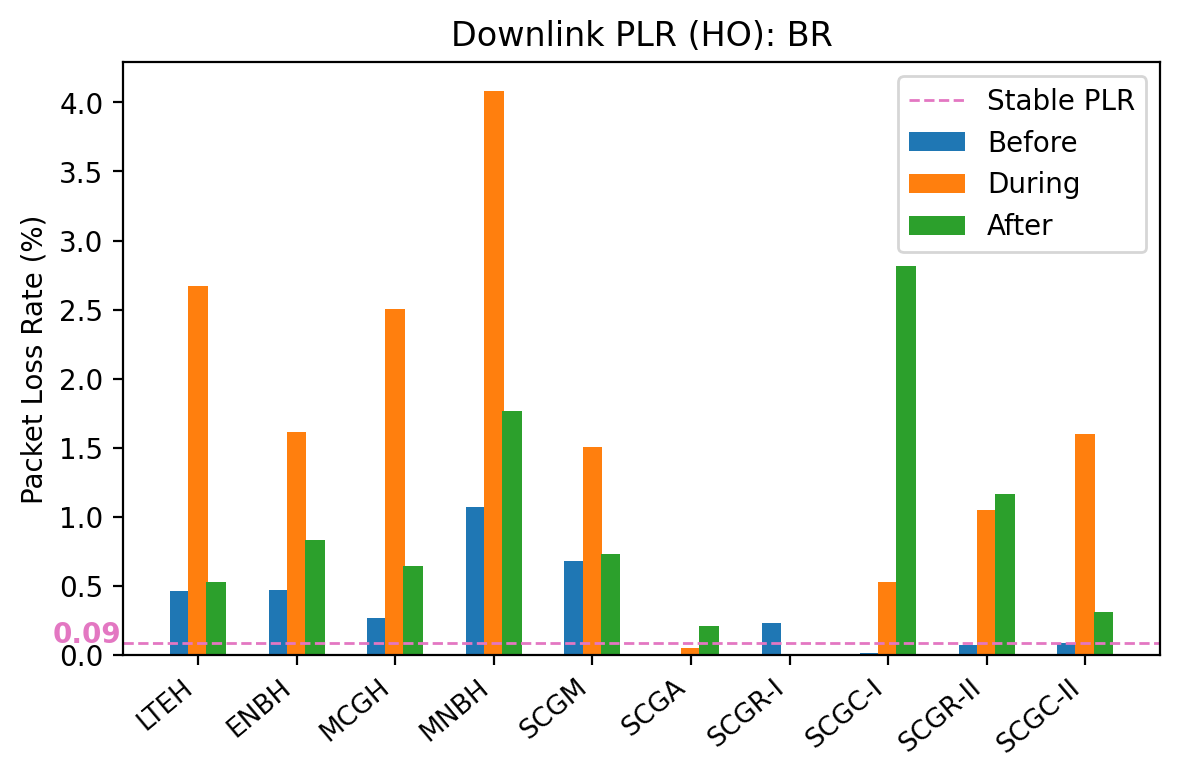

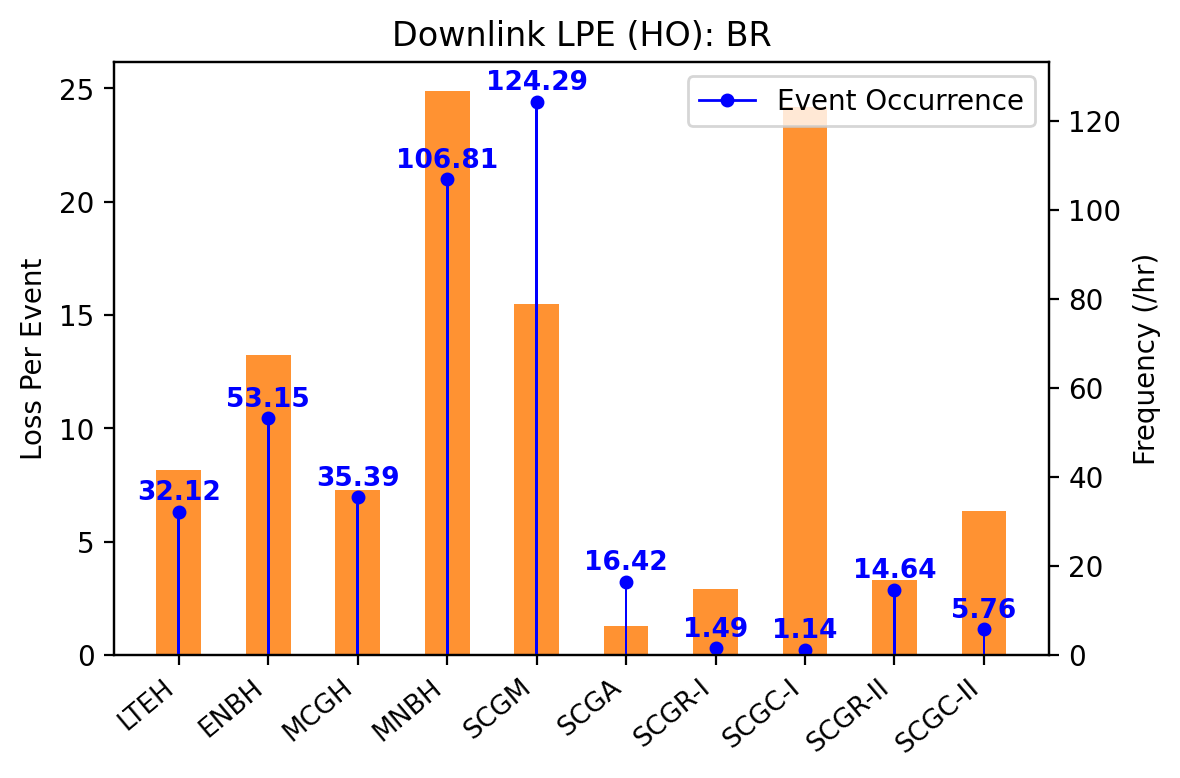

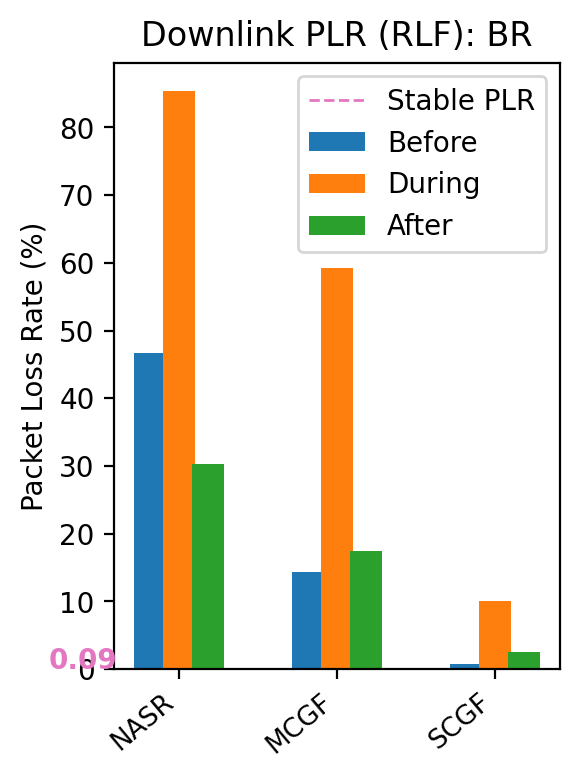

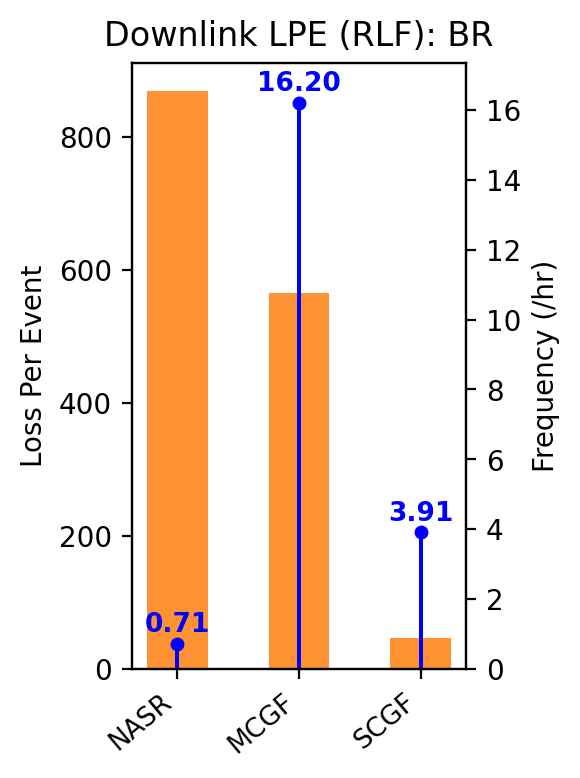

In [99]:
# *********************************** HO ***********************************
ho_types = ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM',
            'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']

df_ho = sr_table_dl[np.in1d(sr_table_dl.index.get_level_values(0), ho_types)].copy().reset_index()
df_ho['type'] = df_ho['type'].astype('category').cat.set_categories(ho_types)
df_ho = df_ho.sort_values(by=['type', 'stage']).reset_index(drop=True)

# *********************************** Loss Rate ***********************************
event_frequency = df_ho.loc[df_ho['stage'] == '-', 'Frequency (/hr)'].to_list()
before_event_loss_rate = df_ho.loc[df_ho['stage'] == 'before', 'lost_r (%)'].to_list()
during_event_loss_rate = df_ho.loc[df_ho['stage'] == 'during', 'lost_r (%)'].to_list()
after_event_loss_rate = df_ho.loc[df_ho['stage'] == 'after', 'lost_r (%)'].to_list()
stable_loss_rate = sr_table_dl.at[('stable', '-'), 'lost_r (%)']

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.55

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_frequency):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR (HO): BR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

# *********************************** Loss Per Event ***********************************
event_frequency = df_ho.loc[df_ho['stage'] == '-', 'Frequency (/hr)'].to_list()
loss_per_event = df_ho.loc[df_ho['stage'] == '-', 'lost_pe'].to_list()

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.55

fig, ax = plt.subplots(figsize=(6, 4))
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_frequency, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Occurrence', linewidth=1)
rect = ax_twin.bar(x, event_frequency, width=0.03, color='blue')
ax_twin.set_ylabel('Frequency (/hr)')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_frequency):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE (HO): BR')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

# *********************************** RLF ***********************************
rlf_types = ['NASR', 'MCGF', 'SCGF']

df_rlf = sr_table_dl[np.in1d(sr_table_dl.index.get_level_values(0), rlf_types)].copy().reset_index()
df_rlf['type'] = df_rlf['type'].astype('category').cat.set_categories(rlf_types)
df_rlf = df_rlf.sort_values(by=['type', 'stage']).reset_index(drop=True)

# *********************************** Loss Rate ***********************************
event_frequency = df_rlf.loc[df_rlf['stage'] == '-', 'Frequency (/hr)'].to_list()
before_event_loss_rate = df_rlf.loc[df_rlf['stage'] == 'before', 'lost_r (%)'].to_list()
during_event_loss_rate = df_rlf.loc[df_rlf['stage'] == 'during', 'lost_r (%)'].to_list()
after_event_loss_rate = df_rlf.loc[df_rlf['stage'] == 'after', 'lost_r (%)'].to_list()
stable_loss_rate = sr_table_dl.at[('stable', '-'), 'lost_r (%)']

x = np.arange(len(rlf_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.55

fig, ax = plt.subplots(figsize=(3, 4))
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_frequency):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR (RLF): BR')
ax.legend()

ax.set_xticks(x, rlf_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

# *********************************** Loss Per Event ***********************************
event_frequency = df_rlf.loc[df_rlf['stage'] == '-', 'Frequency (/hr)'].to_list()
loss_per_event = df_rlf.loc[df_rlf['stage'] == '-', 'lost_pe'].to_list()

x = np.arange(len(rlf_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.55

fig, ax = plt.subplots(figsize=(3, 4))
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_frequency, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Occurrence', linewidth=1)
rect = ax_twin.bar(x, event_frequency, width=0.03, color='blue')
ax_twin.set_ylabel('Frequency (/hr)')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_frequency):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE (RLF): BR')
# ax_twin.legend()

ax.set_xticks(x, rlf_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

In [101]:
# # *********************************** HO ***********************************
# ho_types = ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM',
#             'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']

# df_ho = sr_table_ul[np.in1d(sr_table_ul.index.get_level_values(0), ho_types)].copy().reset_index()
# df_ho['type'] = df_ho['type'].astype('category').cat.set_categories(ho_types)
# df_ho = df_ho.sort_values(by=['type', 'stage']).reset_index(drop=True)

# # *********************************** Loss Rate ***********************************
# event_frequency = df_ho.loc[df_ho['stage'] == '-', 'Frequency (/hr)'].to_list()
# before_event_loss_rate = df_ho.loc[df_ho['stage'] == 'before', 'lost_r (%)'].to_list()
# during_event_loss_rate = df_ho.loc[df_ho['stage'] == 'during', 'lost_r (%)'].to_list()
# after_event_loss_rate = df_ho.loc[df_ho['stage'] == 'after', 'lost_r (%)'].to_list()
# stable_loss_rate = sr_table_ul.at[('stable', '-'), 'lost_r (%)']

# x = np.arange(len(ho_types))  # the label locations
# width = 0.2  # the width of the bars
# space = 0.55

# fig, ax = plt.subplots(figsize=(6, 4))
# rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
# rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
# rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
# ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
# ax.set_ylim(bottom=0)

# xlim = ax.get_xlim()[0]
# ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

# for k, v in enumerate(event_frequency):
#     if v == 0:
#         ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# # Add text for title and custom x-axis tick labels, etc.
# ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Uplink PLR (HO): BR')
# ax.legend()

# ax.set_xticks(x, ho_types)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# fig.tight_layout()
# plt.show()

# # *********************************** Loss Per Event ***********************************
# event_frequency = df_ho.loc[df_ho['stage'] == '-', 'Frequency (/hr)'].to_list()
# loss_per_event = df_ho.loc[df_ho['stage'] == '-', 'lost_pe'].to_list()

# x = np.arange(len(ho_types))  # the label locations
# width = 0.5  # the width of the bars
# space = 0.55

# fig, ax = plt.subplots(figsize=(6, 4))
# rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
# ax.set_ylim(bottom=0)

# ax_twin = ax.twinx()
# ax_twin.plot(x, event_frequency, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
# ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Occurrence', linewidth=1)
# rect = ax_twin.bar(x, event_frequency, width=0.03, color='blue')
# ax_twin.set_ylabel('Frequency (/hr)')

# ax_twin.set_ylim(bottom=0)
# ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
# ylim = ax_twin.get_ylim()[1]

# for k, v in enumerate(event_frequency):
#     if v == 0:
#         ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
#     else:
#         ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# # Add text for title and custom x-axis tick labels, etc.
# ax.set_ylabel('Loss Per Event')
# ax.set_title('Uplink LPE (HO): BR')
# ax_twin.legend()

# ax.set_xticks(x, ho_types)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# fig.tight_layout()
# plt.show()

# # *********************************** RLF ***********************************
# rlf_types = ['NASR', 'MCGF', 'SCGF']

# df_rlf = sr_table_ul[np.in1d(sr_table_ul.index.get_level_values(0), rlf_types)].copy().reset_index()
# df_rlf['type'] = df_rlf['type'].astype('category').cat.set_categories(rlf_types)
# df_rlf = df_rlf.sort_values(by=['type', 'stage']).reset_index(drop=True)

# # *********************************** Loss Rate ***********************************
# event_frequency = df_rlf.loc[df_rlf['stage'] == '-', 'Frequency (/hr)'].to_list()
# before_event_loss_rate = df_rlf.loc[df_rlf['stage'] == 'before', 'lost_r (%)'].to_list()
# during_event_loss_rate = df_rlf.loc[df_rlf['stage'] == 'during', 'lost_r (%)'].to_list()
# after_event_loss_rate = df_rlf.loc[df_rlf['stage'] == 'after', 'lost_r (%)'].to_list()
# stable_loss_rate = sr_table_ul.at[('stable', '-'), 'lost_r (%)']

# x = np.arange(len(rlf_types))  # the label locations
# width = 0.2  # the width of the bars
# space = 0.55

# fig, ax = plt.subplots(figsize=(3, 4))
# rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
# rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
# rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
# ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
# ax.set_ylim(bottom=0)

# xlim = ax.get_xlim()[0]
# ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

# for k, v in enumerate(event_frequency):
#     if v == 0:
#         ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# # Add text for title and custom x-axis tick labels, etc.
# ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Uplink PLR (RLF): BR')
# ax.legend()

# ax.set_xticks(x, rlf_types)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# fig.tight_layout()
# plt.show()

# # *********************************** Loss Per Event ***********************************
# event_frequency = df_rlf.loc[df_rlf['stage'] == '-', 'Frequency (/hr)'].to_list()
# loss_per_event = df_rlf.loc[df_rlf['stage'] == '-', 'lost_pe'].to_list()

# x = np.arange(len(rlf_types))  # the label locations
# width = 0.5  # the width of the bars
# space = 0.55

# fig, ax = plt.subplots(figsize=(3, 4))
# rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
# ax.set_ylim(bottom=0)

# ax_twin = ax.twinx()
# ax_twin.plot(x, event_frequency, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
# ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Occurrence', linewidth=1)
# rect = ax_twin.bar(x, event_frequency, width=0.03, color='blue')
# ax_twin.set_ylabel('Frequency (/hr)')

# ax_twin.set_ylim(bottom=0)
# ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
# ylim = ax_twin.get_ylim()[1]

# for k, v in enumerate(event_frequency):
#     if v == 0:
#         ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
#     else:
#         ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# # Add text for title and custom x-axis tick labels, etc.
# ax.set_ylabel('Loss Per Event')
# ax.set_title('Uplink LPE (RLF): BR')
# # ax_twin.legend()

# ax.set_xticks(x, rlf_types)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# fig.tight_layout()
# plt.show()

In [109]:
df = sr_nasr_table_dl[sr_nasr_table_dl.index.get_level_values(2) == '-'].copy().reset_index()[['type', 'cause', 'Count', 'Frequency (/hr)', 'lost_r (%)', 'lost_pe', 'lost_prop (%)']]
df1 = sr_mcgf_table_dl[sr_mcgf_table_dl.index.get_level_values(2) == '-'].copy().reset_index()[['type', 'cause', 'Count', 'Frequency (/hr)', 'lost_r (%)', 'lost_pe', 'lost_prop (%)']]
df2 = sr_scgf_table_dl[sr_scgf_table_dl.index.get_level_values(2) == '-'].copy().reset_index()[['type', 'cause', 'Count', 'Frequency (/hr)', 'lost_r (%)', 'lost_pe', 'lost_prop (%)']]
df = pd.concat([df, df1, df2])
display(df)

df.to_csv(os.path.join(save_dirpath, 'BR_Single_RLF_Cause.csv'), index=False)

,type,cause,Count,Frequency (/hr),lost_r (%),lost_pe,lost_prop (%)
0,NASR,-,10,0.71,42.314,868.5,3.683
1,NASR,reconfigurationFailure (0),0,0.00,NaN,NaN,0.0
2,NASR,handoverFailure (1),0,0.00,NaN,NaN,0.0
3,NASR,otherFailure (2),10,0.71,42.314,868.5,3.683
0,MCGF,-,228,16.20,16.555,565.04,54.634
1,MCGF,reconfigurationFailure (0),0,0.00,NaN,NaN,0.0
2,MCGF,handoverFailure (1),6,0.43,28.75,784.83,1.997
3,MCGF,otherFailure (2),222,15.78,16.293,559.1,52.637
0,SCGF,-,55,3.91,2.0,46.36,1.081
1,SCGF,t310-Expiry (0),0,0.00,NaN,NaN,0.0


### Dual

In [196]:
df = dr_rate_table[[
    'Count', 'Frequency (/hr)', 'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
    'lost_x_r (%)', 'lost_x_pe', 'lost_y_r (%)', 'lost_y_pe', 'lost_x&y_r (%)', 'lost_x&y_pe', 'lost_x^y_r (%)', 'lost_x^y_pe', 'lost_x|y_r (%)', 'lost_x|y_pe',
    'lost_x_svr (%)', 'lost_y_svr (%)', 'lost_xy_svr (%)', 'lost_x_bsr (%)', 'lost_y_bsr (%)', 'lost_xy_bsr (%)',
    'lost_x_prop (%)', 'lost_y_prop (%)', 'lost_x&y_prop (%)', 'lost_x^y_prop (%)', 'lost_x|y_prop (%)',
    'lost_x_prop_roc (%)', 'lost_y_prop_roc (%)', 'lost_xy_prop_roc (%)',
    'total_sent', 'exp_duration (min)'
]].copy()

df1 = dr_cnt_table[['lost_x', 'lost_y', 'lost_x&y', 'lost_x^y', 'lost_x|y']].copy()

df = pd.concat([df, df1], axis=1)
del df1

df['lost_x_reduct'] = (df['lost_x&y'] - df['lost_x']).abs()
df['lost_y_reduct'] = (df['lost_x&y'] - df['lost_y']).abs()
df['lost_xy_reduct'] = (df['lost_x&y'] - df['lost_x|y']).abs()
df['lost_x_rr (%)'] = ((df['lost_x&y'] - df['lost_x']) / df['lost_x'] * 100).round(2).abs()
df['lost_y_rr (%)'] = ((df['lost_x&y'] - df['lost_y']) / df['lost_y'] * 100).round(2).abs()
df['lost_xy_rr (%)'] = ((df['lost_x&y'] - df['lost_x|y']) / df['lost_x|y'] * 100).round(2).abs()

df = df[[
    'Count', 'Frequency (/hr)',
    'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
    'lost_x_pe', 'lost_x&y_pe',
    'lost_x', 'lost_x&y', 'lost_x_reduct', 'lost_x_rr (%)',
    'lost_x_r (%)', 'lost_x&y_r (%)', 'lost_x_svr (%)', 'lost_x_bsr (%)',
    'lost_x_prop (%)', 'lost_x&y_prop (%)', 'lost_x_prop_roc (%)',
    'total_sent', 'exp_duration (min)',
]]

ho_types = [
    'NASR', 'MCGF', 'SCGF',
    'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM',
    'stable',
]
ho_combos = list(it.combinations_with_replacement(ho_types, 2))
rows_to_drop = []
for combo in ho_combos:
    if combo[0] == combo[1]:
        continue
    rows_to_drop.append((combo[1], combo[0]))

df.loc[('stable', 'stable'), ['Count', 'Frequency (/hr)']] = -1
df.loc[('stable', 'stable'), ['lost_x_pe', 'lost_x&y_pe']] = np.nan
# df.at[('stable', 'stable'), 'Average Overlapping Duration (sec)'] = np.nan
    
# 使用 drop 函數刪除指定行
df = df.drop(rows_to_drop).copy().reset_index()

# *********************************** Sorting ***********************************
df['Frequency (/hr) rank'] = df['Frequency (/hr)'].rank(ascending=False, method='min').round().astype('Int16')
df['Total Overlapping Duration rank'] = df['Total Overlapping Duration (sec)'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x&y_pe rank'] = df['lost_x&y_pe'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x_reduct rank'] = df['lost_x_reduct'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x_rr (%) rank_des'] = df['lost_x_rr (%)'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x_rr (%) rank_asc'] = df['lost_x_rr (%)'].rank(ascending=True, method='min').round().astype('Int16')
df['lost_x&y_r (%) rank'] = df['lost_x&y_r (%)'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x_svr (%) rank'] = df['lost_x_svr (%)'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x_bsr (%) rank'] = df['lost_x_bsr (%)'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x&y_prop (%) rank'] = df['lost_x&y_prop (%)'].rank(ascending=False, method='min').round().astype('Int16')
df['lost_x_prop_roc (%) rank_asc'] = df['lost_x_prop_roc (%)'].rank(ascending=True, method='min').round().astype('Int16')
df['lost_x_prop_roc (%) rank_des'] = df['lost_x_prop_roc (%)'].rank(ascending=False, method='min').round().astype('Int16')

df = df[[
    'type_x', 'type_y',
    # 'Count', 'Frequency (/hr)', 'Frequency (/hr) rank', 
    'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)', 'Total Overlapping Duration rank',
    # 'lost_x&y_pe', 'lost_x&y_pe rank',
    'lost_x', 'lost_x&y',
    'lost_x_reduct', 'lost_x_reduct rank', 'lost_x_rr (%)', 'lost_x_rr (%) rank_des', #'lost_x_rr (%) rank_asc',
    'lost_x_r (%)', 'lost_x&y_r (%)', 'lost_x&y_r (%) rank', 'lost_x_svr (%)', 'lost_x_svr (%) rank', 'lost_x_bsr (%)', 'lost_x_bsr (%) rank',
    'lost_x_prop (%)', 'lost_x&y_prop (%)', 'lost_x&y_prop (%) rank',
    # 'lost_x_prop_roc (%)', 'lost_x_prop_roc (%) rank_asc', 'lost_x_prop_roc (%) rank_des',
    'total_sent', #'exp_duration (min)',
]]

interest_events = ['MNBH', 'ENBH', 'SCGM', 'MCGF', 'NASR', 'SCGF', 'stable']

print('lost_x&y_prop (%)')
display(df.sort_values(by='lost_x&y_prop (%)', ascending=False).reset_index(drop=True).copy().iloc[:10])
df.sort_values(by='lost_x&y_prop (%)', ascending=False).reset_index(drop=True).copy().iloc[:10].to_csv(os.path.join(save_dirpath, 'BR_lost_x&y_prop (%).csv'), index=False)

print('lost_x_reduct (Reduction)')
tmp = df.sort_values(by='lost_x_reduct', ascending=False).reset_index(drop=True).copy().iloc[:]
display(tmp[np.in1d(tmp['type_x'], interest_events)].reset_index(drop=True).copy().iloc[:10])
tmp[np.in1d(tmp['type_x'], interest_events)].reset_index(drop=True).copy().iloc[:10].to_csv(os.path.join(save_dirpath, 'BR_lost_x_reduct (Reduction).csv'), index=False)

print('lost_x_svr (%)')
tmp = df.sort_values(by='lost_x_svr (%)', ascending=False).reset_index(drop=True).copy().iloc[:]
display(tmp[np.in1d(tmp['type_x'], interest_events)].reset_index(drop=True).copy().iloc[:10])
tmp[np.in1d(tmp['type_x'], interest_events)].reset_index(drop=True).copy().iloc[:10].to_csv(os.path.join(save_dirpath, 'BR_lost_x_svr (%).csv'), index=False)

print('lost_x_bsr (%)')
display(df.sort_values(by='lost_x_bsr (%)', ascending=False).reset_index(drop=True).copy().iloc[:10])
df.sort_values(by='lost_x_bsr (%)', ascending=False).reset_index(drop=True).copy().iloc[:10].to_csv(os.path.join(save_dirpath, 'BR_lost_x_bsr (%).csv'), index=False)

# print('Occurring Frequency')
# display(df.sort_values(by='Frequency (/hr)', ascending=False).reset_index(drop=True).copy().iloc[:10])
# print('lost_x&y per Event')
# display(df.sort_values(by='lost_x&y_pe', ascending=False).reset_index(drop=True).copy().iloc[:10])
# print('lost_x_rr (Reduction Rate) descending')
# display(df[df['lost_x_rr (%)'] == 100].sort_values(by='lost_x_rr (%)', ascending=False).reset_index(drop=True).copy())
# print('lost_x_rr (Reduction Rate) ascending')
# display(df.sort_values(by='lost_x_rr (%)', ascending=True).reset_index(drop=True).copy().iloc[:10])
# print('lost_x&y_r (%)')
# display(df.sort_values(by='lost_x&y_r (%)', ascending=False).reset_index(drop=True).copy().iloc[:10])
# print('lost_x&y_prop_roc (%) ascending')
# display(df.sort_values(by='lost_x_prop_roc (%)', ascending=True).reset_index(drop=True).copy().iloc[:10])
# print('lost_x&y_prop_roc (%) descending')
# display(df.sort_values(by='lost_x_prop_roc (%)', ascending=False).reset_index(drop=True).copy().iloc[:10])

lost_x&y_prop (%)


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,MCGF,MCGF,3342.488,0.824,12,276112,121646,154466,3,55.94,84,16.892,7.442,3,55.943,84,44.057,6,14.637,44.460,1,1634558
1,MNBH,MNBH,15446.307,3.808,4,110524,17724,92800,6,83.96,73,1.442,0.231,20,83.964,73,16.036,17,5.859,6.478,2,7663924
2,MCGF,MNBH,1952.171,0.481,20,204616,15694,188922,1,92.33,63,21.816,1.673,10,92.330,63,7.670,27,10.847,5.736,3,937924
3,stable,stable,180314.248,44.450,1,63772,8204,55568,9,87.14,68,0.069,0.009,58,87.135,68,12.865,22,3.381,2.998,4,91896248
4,SCGM,SCGM,25699.062,6.335,2,92857,7806,85051,7,91.59,66,0.728,0.061,30,91.594,66,8.406,24,4.922,2.853,5,12748972
5,MCGF,ENBH,1357.499,0.335,23,113153,6686,106467,5,94.09,58,17.826,1.053,12,94.091,58,5.909,32,5.998,2.444,6,634773
6,ENBH,ENBH,7431.630,1.832,6,21565,6508,15057,16,69.82,82,0.593,0.179,22,69.821,82,30.179,8,1.143,2.379,7,3633540
7,MCGF,SCGM,2275.080,0.561,19,182357,5078,177279,2,97.22,41,16.595,0.462,19,97.215,41,2.785,49,9.667,1.856,8,1098885
8,NASR,NASR,33.478,0.008,71,6478,4788,1690,40,26.09,86,40.281,29.772,2,26.088,86,73.912,4,0.343,1.750,9,16082
9,MNBH,stable,10860.237,2.677,5,62259,3250,59009,8,94.78,52,1.157,0.060,31,94.780,52,5.220,38,3.300,1.188,10,5381663


lost_x_reduct (Reduction)


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,MCGF,MNBH,1952.171,0.481,20,204616,15694,188922,1,92.33,63,21.816,1.673,10,92.330,63,7.670,27,10.847,5.736,3,937924
1,MCGF,SCGM,2275.080,0.561,19,182357,5078,177279,2,97.22,41,16.595,0.462,19,97.215,41,2.785,49,9.667,1.856,8,1098885
2,MCGF,MCGF,3342.488,0.824,12,276112,121646,154466,3,55.94,84,16.892,7.442,3,55.943,84,44.057,6,14.637,44.460,1,1634558
3,MCGF,stable,2741.790,0.676,15,123137,1419,121718,4,98.85,35,10.084,0.116,25,98.848,35,1.152,55,6.527,0.519,15,1221076
4,MCGF,ENBH,1357.499,0.335,23,113153,6686,106467,5,94.09,58,17.826,1.053,12,94.091,58,5.909,32,5.998,2.444,6,634773
5,MNBH,MNBH,15446.307,3.808,4,110524,17724,92800,6,83.96,73,1.442,0.231,20,83.964,73,16.036,17,5.859,6.478,2,7663924
6,SCGM,SCGM,25699.062,6.335,2,92857,7806,85051,7,91.59,66,0.728,0.061,30,91.594,66,8.406,24,4.922,2.853,5,12748972
7,MNBH,stable,10860.237,2.677,5,62259,3250,59009,8,94.78,52,1.157,0.060,31,94.780,52,5.220,38,3.300,1.188,10,5381663
8,stable,stable,180314.248,44.450,1,63772,8204,55568,9,87.14,68,0.069,0.009,58,87.135,68,12.865,22,3.381,2.998,4,91896248
9,MCGF,LTEH,559.064,0.138,30,47929,2719,45210,10,94.33,55,18.720,1.062,11,94.327,55,5.673,35,2.541,0.994,12,256029


lost_x_svr (%)


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,SCGF,LTEH,59.042,0.015,61,646,0,646,54,100.00,1,2.197,0.000,67,100.000,1,0.000,67,0.034,0.000,62,29399
1,SCGF,stable,1410.011,0.348,22,1171,0,1171,48,100.00,1,0.169,0.000,67,100.000,1,0.000,67,0.062,0.000,62,694792
2,SCGF,SCGR-I,30.100,0.007,73,9,0,9,83,100.00,1,0.060,0.000,67,100.000,1,0.000,67,0.000,0.000,62,15052
3,SCGF,SCGC-I,2.097,0.001,96,1,0,1,85,100.00,1,0.094,0.000,67,100.000,1,0.000,67,0.000,0.000,62,1061
4,MCGF,SCGC-I,27.078,0.007,74,1772,0,1772,38,100.00,1,13.428,0.000,67,100.000,1,0.000,67,0.094,0.000,62,13196
5,NASR,SCGC-II,1.375,0.000,97,259,0,259,66,100.00,1,37.700,0.000,67,100.000,1,0.000,67,0.014,0.000,62,687
6,NASR,stable,71.868,0.018,58,13386,0,13386,19,100.00,1,41.715,0.000,67,100.000,1,0.000,67,0.710,0.000,62,32089
7,SCGF,SCGC-II,12.466,0.003,87,1550,1,1549,43,99.94,24,25.327,0.016,51,99.935,24,0.065,66,0.082,0.000,62,6120
8,SCGF,ENBH,65.148,0.016,60,1660,5,1655,41,99.70,26,5.166,0.016,51,99.699,26,0.301,64,0.088,0.002,58,32132
9,MCGF,SCGA,114.541,0.028,48,8514,47,8467,23,99.45,29,16.595,0.092,26,99.448,29,0.552,61,0.451,0.017,41,51305


lost_x_bsr (%)


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,SCGR-II,SCGC-II,14.125,0.003,84,5,5,0,88,0.00,88,0.078,0.078,27,0.000,88,100.000,1,0.000,0.002,58,6449
1,SCGA,SCGR-II,12.766,0.003,86,1,1,0,88,0.00,88,0.019,0.019,48,0.000,88,100.000,1,0.000,0.000,62,5387
2,SCGF,MCGH,15.747,0.004,83,46,45,1,85,2.17,87,0.599,0.586,17,2.174,87,97.826,3,0.002,0.016,42,7682
3,NASR,NASR,33.478,0.008,71,6478,4788,1690,40,26.09,86,40.281,29.772,2,26.088,86,73.912,4,0.343,1.750,9,16082
4,NASR,MCGF,19.697,0.005,82,4762,2928,1834,37,38.51,85,60.294,37.073,1,38.513,85,61.487,5,0.252,1.070,11,7898
5,MCGF,MCGF,3342.488,0.824,12,276112,121646,154466,3,55.94,84,16.892,7.442,3,55.943,84,44.057,6,14.637,44.460,1,1634558
6,LTEH,LTEH,2364.468,0.583,18,1904,672,1232,46,64.71,83,0.162,0.057,33,64.706,83,35.294,7,0.101,0.246,23,1173398
7,ENBH,ENBH,7431.630,1.832,6,21565,6508,15057,16,69.82,82,0.593,0.179,22,69.821,82,30.179,8,1.143,2.379,7,3633540
8,SCGA,MCGH,96.470,0.024,53,63,17,46,77,73.02,81,0.132,0.036,39,73.016,81,26.984,9,0.003,0.006,51,47885
9,LTEH,ENBH,788.692,0.194,26,3227,865,2362,36,73.19,80,0.859,0.230,21,73.195,80,26.805,10,0.171,0.316,18,375469


In [237]:
df = dr_rate_table[[
    'Count', 'Frequency (/hr)', 'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
    'lost_x_r (%)', 'lost_x_pe', 'lost_y_r (%)', 'lost_y_pe', 'lost_x&y_r (%)', 'lost_x&y_pe', 'lost_x^y_r (%)', 'lost_x^y_pe', 'lost_x|y_r (%)', 'lost_x|y_pe',
    'lost_x_svr (%)', 'lost_y_svr (%)', 'lost_xy_svr (%)', 'lost_x_bsr (%)', 'lost_y_bsr (%)', 'lost_xy_bsr (%)',
    'lost_x_prop (%)', 'lost_y_prop (%)', 'lost_x&y_prop (%)', 'lost_x^y_prop (%)', 'lost_x|y_prop (%)',
    'lost_x_prop_roc (%)', 'lost_y_prop_roc (%)', 'lost_xy_prop_roc (%)',
    'total_sent', 'exp_duration (min)'
]].copy()

df1 = dr_cnt_table[['lost_x', 'lost_y', 'lost_x&y', 'lost_x^y', 'lost_x|y']].copy()

df = pd.concat([df, df1], axis=1)
del df1

df['lost_x_reduct'] = (df['lost_x&y'] - df['lost_x']).abs()
df['lost_y_reduct'] = (df['lost_x&y'] - df['lost_y']).abs()
df['lost_xy_reduct'] = (df['lost_x&y'] - df['lost_x|y']).abs()
df['lost_x_rr (%)'] = ((df['lost_x&y'] - df['lost_x']) / df['lost_x'] * 100).round(2).abs()
df['lost_y_rr (%)'] = ((df['lost_x&y'] - df['lost_y']) / df['lost_y'] * 100).round(2).abs()
df['lost_xy_rr (%)'] = ((df['lost_x&y'] - df['lost_x|y']) / df['lost_x|y'] * 100).round(2).abs()

df = df[[
    'Count', 'Frequency (/hr)',
    'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
    'lost_x_pe', 'lost_x&y_pe',
    'lost_x', 'lost_x&y', 'lost_x_reduct', 'lost_x_rr (%)',
    'lost_x_r (%)', 'lost_x&y_r (%)', 'lost_x_svr (%)', 'lost_x_bsr (%)',
    'lost_x_prop (%)', 'lost_x&y_prop (%)', 'lost_x_prop_roc (%)',
    'total_sent', 'exp_duration (min)',
]].reset_index()

df1 = df.copy()

# *********************************** Focus & Sorting ***********************************
interest_events = ['MCGF', 'NASR', 'SCGF', 'MNBH', 'ENBH', 'SCGM']
for tag in interest_events:
    df = df1[df1['type_x'] == tag].copy().reset_index(drop=True)
    
    df['Frequency (/hr) rank'] = df['Frequency (/hr)'].rank(ascending=False, method='min').round().astype('Int16')
    df['Total Overlapping Duration rank'] = df['Total Overlapping Duration (sec)'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x&y_pe rank'] = df['lost_x&y_pe'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x_reduct rank'] = df['lost_x_reduct'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x_rr (%) rank_des'] = df['lost_x_rr (%)'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x_rr (%) rank_asc'] = df['lost_x_rr (%)'].rank(ascending=True, method='min').round().astype('Int16')
    df['lost_x&y_r (%) rank'] = df['lost_x&y_r (%)'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x_svr (%) rank'] = df['lost_x_svr (%)'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x_bsr (%) rank'] = df['lost_x_bsr (%)'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x&y_prop (%) rank'] = df['lost_x&y_prop (%)'].rank(ascending=False, method='min').round().astype('Int16')
    df['lost_x_prop_roc (%) rank_asc'] = df['lost_x_prop_roc (%)'].rank(ascending=True, method='min').round().astype('Int16')
    df['lost_x_prop_roc (%) rank_des'] = df['lost_x_prop_roc (%)'].rank(ascending=False, method='min').round().astype('Int16')

    df = df[[
        'type_x', 'type_y',
        # 'Count', 'Frequency (/hr)', 'Frequency (/hr) rank', 
        'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)', 'Total Overlapping Duration rank',
        # 'lost_x&y_pe', 'lost_x&y_pe rank',
        'lost_x', 'lost_x&y',
        'lost_x_reduct', 'lost_x_reduct rank', 'lost_x_rr (%)', 'lost_x_rr (%) rank_des', #'lost_x_rr (%) rank_asc',
        'lost_x_r (%)', 'lost_x&y_r (%)', 'lost_x&y_r (%) rank', 'lost_x_svr (%)', 'lost_x_svr (%) rank', 'lost_x_bsr (%)', 'lost_x_bsr (%) rank',
        'lost_x_prop (%)', 'lost_x&y_prop (%)', 'lost_x&y_prop (%) rank',
        # 'lost_x_prop_roc (%)', 'lost_x_prop_roc (%) rank_asc', 'lost_x_prop_roc (%) rank_des',
        'total_sent', #'exp_duration (min)',
    ]]
    
    # print('lost_x_rr (Reduction Rate) descending')
    df = df.sort_values(by='lost_x_rr (%)', ascending=False).reset_index(drop=True).copy()
    
    # ********************* add more columns *********************
    
    col_sums = df.set_index(['type_x', 'type_y']).copy().sum()
    df.loc[-1] = [tag, '-', *col_sums]
    df.index = df.index + 1
    df = df.sort_index().set_index(['type_x', 'type_y'])
    
    df.loc[(tag, '-'), ['Total Overlapping Duration rank', 'lost_x_reduct rank', 'lost_x_rr (%) rank_des', 'lost_x&y_r (%) rank', 'lost_x_svr (%) rank', 'lost_x_bsr (%) rank', 'lost_x&y_prop (%) rank']] = 0
    df[['Total Overlapping Duration rank', 'lost_x_reduct rank', 'lost_x_rr (%) rank_des', 'lost_x&y_r (%) rank', 'lost_x_svr (%) rank', 'lost_x_bsr (%) rank', 'lost_x&y_prop (%) rank']] = \
        df[['Total Overlapping Duration rank', 'lost_x_reduct rank', 'lost_x_rr (%) rank_des', 'lost_x&y_r (%) rank', 'lost_x_svr (%) rank', 'lost_x_bsr (%) rank', 'lost_x&y_prop (%) rank']].astype('Int64')
    df[['lost_x', 'lost_x&y', 'lost_x_reduct', 'total_sent']] = df[['lost_x', 'lost_x&y', 'lost_x_reduct', 'total_sent']].astype('Int64')
    
    (df['lost_x&y'] - df['lost_x']) / df['lost_x']
    df.at[(tag, '-'), 'lost_x_rr (%)'] = abs((df.at[(tag, '-'), 'lost_x&y'] - df.at[(tag, '-'), 'lost_x']) / df.at[(tag, '-'), 'lost_x'] * 100)
    df.at[(tag, '-'), 'lost_x_r (%)'] = (df.at[(tag, '-'), 'lost_x'] / df.at[(tag, '-'), 'total_sent'] * 100).round(3)
    df.at[(tag, '-'), 'lost_x&y_r (%)'] = (df.at[(tag, '-'), 'lost_x&y'] / df.at[(tag, '-'), 'total_sent'] * 100).round(3)
    df.at[(tag, '-'), 'lost_x_bsr (%)'] = (df.at[(tag, '-'), 'lost_x&y'] / df.at[(tag, '-'), 'lost_x'] * 100).round(3)
    df.at[(tag, '-'), 'lost_x_svr (%)'] = 100 - df.at[(tag, '-'), 'lost_x_bsr (%)']
    
    

    
    
    total_lost_x = df.at[(tag, '-'), 'lost_x']
    df['Total Reduction Rate (%)'] = ((df['lost_x_reduct'] / total_lost_x) * 100).round(3)
    df['Total Reduction Rate (%) rank'] = df['Total Reduction Rate (%)'].rank(ascending=False, method='min').round().astype('Int16') - 1
    
    df = df[[
        # 'Count', 'Frequency (/hr)', 'Frequency (/hr) rank', 
        'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)', 'Total Overlapping Duration rank',
        # 'lost_x&y_pe', 'lost_x&y_pe rank',
        'lost_x', 'lost_x&y',
        'lost_x_reduct', 'lost_x_reduct rank', 'Total Reduction Rate (%)', 'Total Reduction Rate (%) rank',
        'lost_x_rr (%)', 'lost_x_rr (%) rank_des', #'lost_x_rr (%) rank_asc',
        'lost_x_r (%)', 'lost_x&y_r (%)', 'lost_x&y_r (%) rank', 'lost_x_svr (%)', 'lost_x_svr (%) rank', 'lost_x_bsr (%)', 'lost_x_bsr (%) rank',
        'lost_x_prop (%)', 'lost_x&y_prop (%)', 'lost_x&y_prop (%) rank',
        # 'lost_x_prop_roc (%)', 'lost_x_prop_roc (%) rank_asc', 'lost_x_prop_roc (%) rank_des',
        'total_sent', #'exp_duration (min)',
    ]].reset_index()
    
    print(tag)
    display(df)
    df.to_csv(os.path.join(save_dirpath, f'BR_{tag}.csv'), index=False)
    # break

MCGF


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,Total Reduction Rate (%),Total Reduction Rate (%) rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,MCGF,-,13158.605,3.244,0,1030640,159038,871602,0,84.569,0,84.569006,0,16.555,2.555,0,84.569,0,15.431,0,54.635,58.127,0,6225648
1,MCGF,SCGC-I,27.078,0.007,11,1772,0,1772,12,0.172,12,100.000000,1,13.428,0.000,13,100.000,1,0.000,13,0.094,0.000,13,13196
2,MCGF,SCGA,114.541,0.028,9,8514,47,8467,9,0.822,9,99.450000,2,16.595,0.092,12,99.448,2,0.552,12,0.451,0.017,12,51305
3,MCGF,SCGC-II,151.458,0.037,8,16351,95,16256,8,1.577,8,99.420000,3,22.166,0.129,10,99.419,3,0.581,11,0.867,0.035,11,73765
4,MCGF,stable,2741.790,0.676,2,123137,1419,121718,4,11.81,4,98.850000,4,10.084,0.116,11,98.848,4,1.152,10,6.527,0.519,8,1221076
5,MCGF,SCGM,2275.080,0.561,3,182357,5078,177279,2,17.201,2,97.220000,5,16.595,0.462,9,97.215,5,2.785,9,9.667,1.856,4,1098885
6,MCGF,MCGH,493.315,0.122,7,40146,1616,38530,7,3.738,7,95.970000,6,16.839,0.678,8,95.975,6,4.025,8,2.128,0.591,7,238408
7,MCGF,SCGR-II,98.380,0.024,10,6910,387,6523,10,0.633,10,94.400000,7,15.185,0.850,7,94.399,7,5.601,7,0.366,0.141,10,45506
8,MCGF,LTEH,559.064,0.138,6,47929,2719,45210,6,4.387,6,94.330000,8,18.720,1.062,5,94.327,8,5.673,6,2.541,0.994,6,256029
9,MCGF,ENBH,1357.499,0.335,5,113153,6686,106467,5,10.33,5,94.090000,9,17.826,1.053,6,94.091,9,5.909,5,5.998,2.444,3,634773


NASR


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,Total Reduction Rate (%),Total Reduction Rate (%) rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,NASR,-,354.430,0.087,0,69480,10702,58778,0,84.597,0,84.597006,0,42.314,6.518,0,84.597,0,15.403,0,3.682,3.912,0,164200
1,NASR,SCGC-II,1.375,0.000,10,259,0,259,9,0.373,9,100.000000,1,37.700,0.000,8,100.000,1,0.000,8,0.014,0.000,8,687
2,NASR,stable,71.868,0.018,2,13386,0,13386,2,19.266,2,100.000000,1,41.715,0.000,8,100.000,1,0.000,8,0.710,0.000,8,32089
3,NASR,ENBH,55.569,0.014,3,15019,656,14363,1,20.672,1,95.630000,3,57.964,2.532,5,95.632,3,4.368,7,0.796,0.240,5,25911
4,NASR,MNBH,50.437,0.012,4,8206,394,7812,4,11.244,4,95.200000,4,35.465,1.703,7,95.199,4,4.801,6,0.435,0.144,6,23138
5,NASR,SCGM,77.542,0.019,1,12588,858,11730,3,16.883,3,93.180000,5,33.912,2.311,6,93.184,5,6.816,5,0.667,0.314,3,37120
6,NASR,MCGH,20.110,0.005,7,4983,394,4589,5,6.605,5,92.090000,6,54.057,4.274,4,92.093,6,7.907,4,0.264,0.144,6,9218
7,NASR,LTEH,20.225,0.005,6,3799,684,3115,6,4.483,6,82.000000,7,38.036,6.848,3,81.995,7,18.005,3,0.201,0.250,4,9988
8,NASR,MCGF,19.697,0.005,8,4762,2928,1834,7,2.64,7,38.510000,8,60.294,37.073,1,38.513,8,61.487,2,0.252,1.070,2,7898
9,NASR,NASR,33.478,0.008,5,6478,4788,1690,8,2.432,8,26.090000,9,40.281,29.772,2,26.088,9,73.912,1,0.343,1.750,1,16082


SCGF


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,Total Reduction Rate (%),Total Reduction Rate (%) rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,SCGF,-,2070.986,0.511,0,20400,2085,18315,0,89.779,0,89.779412,0,2.000,0.204,0,89.779,0,10.221,0,1.079,0.761,0,1020208
1,SCGF,SCGR-I,30.100,0.007,8,9,0,9,8,0.044,8,100.000000,1,0.060,0.000,9,100.000,1,0.000,9,0.000,0.000,7,15052
2,SCGF,SCGC-I,2.097,0.001,14,1,0,1,10,0.005,10,100.000000,1,0.094,0.000,9,100.000,1,0.000,9,0.000,0.000,7,1061
3,SCGF,LTEH,59.042,0.015,5,646,0,646,6,3.167,6,100.000000,1,2.197,0.000,9,100.000,1,0.000,9,0.034,0.000,7,29399
4,SCGF,stable,1410.011,0.348,1,1171,0,1171,5,5.74,5,100.000000,1,0.169,0.000,9,100.000,1,0.000,9,0.062,0.000,7,694792
5,SCGF,SCGC-II,12.466,0.003,11,1550,1,1549,4,7.593,4,99.940000,5,25.327,0.016,7,99.935,5,0.065,8,0.082,0.000,7,6120
6,SCGF,ENBH,65.148,0.016,4,1660,5,1655,3,8.113,3,99.700000,6,5.166,0.016,7,99.699,6,0.301,7,0.088,0.002,6,32132
7,SCGF,MNBH,139.648,0.034,3,4150,331,3819,2,18.721,2,92.020000,7,6.001,0.479,5,92.024,7,7.976,6,0.220,0.121,3,69152
8,SCGF,SCGM,230.381,0.057,2,9959,851,9108,1,44.647,1,91.450000,8,8.850,0.756,2,91.455,8,8.545,5,0.528,0.311,1,112532
9,SCGF,SCGR-II,3.849,0.001,13,4,1,3,9,0.015,9,75.000000,9,0.209,0.052,6,75.000,9,25.000,4,0.000,0.000,7,1914


MNBH


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,Total Reduction Rate (%),Total Reduction Rate (%) rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,MNBH,-,43132.230,10.632,0,299456,40505,258951,0,86.474,0,86.473806,0,1.407,0.190,0,86.474,0,13.526,0,15.874,14.805,0,21289704
1,MNBH,SCGC-I,22.009,0.005,13,142,0,142,12,0.047,12,100.000000,1,1.368,0.000,13,100.000,1,0.000,13,0.008,0.000,13,10378
2,MNBH,SCGC-II,306.349,0.076,8,2265,10,2255,8,0.753,8,99.560000,2,1.506,0.007,12,99.558,2,0.442,12,0.120,0.004,12,150409
3,MNBH,ENBH,6091.975,1.502,4,37035,639,36396,4,12.154,4,98.270000,3,1.241,0.021,11,98.275,3,1.725,11,1.963,0.234,5,2983205
4,MNBH,MCGH,960.255,0.237,6,4028,144,3884,6,1.297,6,96.430000,4,0.844,0.030,10,96.425,4,3.575,10,0.214,0.053,9,477473
5,MNBH,SCGM,6322.534,1.559,3,45604,1941,43663,3,14.581,3,95.740000,5,1.460,0.062,7,95.744,5,4.256,9,2.417,0.709,4,3123448
6,MNBH,stable,10860.237,2.677,2,62259,3250,59009,2,19.705,2,94.780000,6,1.157,0.060,8,94.780,6,5.220,8,3.300,1.188,3,5381663
7,MNBH,SCGA,190.557,0.047,9,517,30,487,9,0.163,9,94.200000,7,0.569,0.033,9,94.197,7,5.803,7,0.027,0.011,11,90895
8,MNBH,LTEH,622.386,0.153,7,2991,225,2766,7,0.924,7,92.480000,8,1.008,0.076,6,92.477,8,7.523,6,0.159,0.082,8,296611
9,MNBH,MNBH,15446.307,3.808,1,110524,17724,92800,1,30.99,1,83.960000,9,1.442,0.231,4,83.964,9,16.036,5,5.859,6.478,1,7663924


ENBH


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,Total Reduction Rate (%),Total Reduction Rate (%) rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,ENBH,-,26788.243,6.603,0,79064,16990,62074,0,78.511,0,78.51108,0,0.608,0.131,0,78.511,0,21.489,0,4.191,6.211,0,13003699
1,ENBH,SCGC-II,258.392,0.064,8,520,3,517,7,0.654,7,99.42000,1,0.420,0.002,12,99.423,1,0.577,12,0.028,0.001,11,123869
2,ENBH,MCGH,642.175,0.158,7,1208,32,1176,6,1.487,6,97.35000,2,0.383,0.010,10,97.351,2,2.649,11,0.064,0.012,8,315132
3,ENBH,SCGF,65.148,0.016,11,179,5,174,10,0.22,10,97.21000,3,0.557,0.016,9,97.207,3,2.793,10,0.009,0.002,10,32132
4,ENBH,MNBH,6091.975,1.502,2,14687,639,14048,3,17.768,3,95.65000,4,0.492,0.021,7,95.649,4,4.351,9,0.779,0.234,6,2983205
5,ENBH,SCGM,4577.659,1.128,4,20585,1120,19465,1,24.619,1,94.56000,5,0.926,0.050,5,94.559,5,5.441,8,1.091,0.409,3,2222833
6,ENBH,SCGR-II,113.736,0.028,9,361,22,339,8,0.429,8,93.91000,6,0.661,0.040,6,93.906,6,6.094,7,0.019,0.008,9,54588
7,ENBH,stable,5238.481,1.291,3,6012,451,5561,4,7.034,4,92.50000,7,0.238,0.018,8,92.498,7,7.502,6,0.319,0.165,7,2522342
8,ENBH,ENBH,7431.630,1.832,1,21565,6508,15057,2,19.044,2,69.82000,8,0.593,0.179,4,69.821,8,30.179,5,1.143,2.379,2,3633540
9,ENBH,SCGA,106.840,0.026,10,8,3,5,12,0.006,12,62.50000,9,0.016,0.006,11,62.500,9,37.500,4,0.000,0.001,11,50577


SCGM


,type_x,type_y,Total Overlapping Duration (sec),Total Overlapping Duration (%),Total Overlapping Duration rank,lost_x,lost_x&y,lost_x_reduct,lost_x_reduct rank,Total Reduction Rate (%),Total Reduction Rate (%) rank,lost_x_rr (%),lost_x_rr (%) rank_des,lost_x_r (%),lost_x&y_r (%),lost_x&y_r (%) rank,lost_x_svr (%),lost_x_svr (%) rank,lost_x_bsr (%),lost_x_bsr (%) rank,lost_x_prop (%),lost_x&y_prop (%),lost_x&y_prop (%) rank,total_sent
0,SCGM,-,61919.776,15.263,0,216312,19723,196589,0,90.882,0,90.882152,0,0.708,0.065,0,90.882,0,9.118,0,11.465,7.209,0,30573258
1,SCGM,SCGC-II,715.054,0.176,8,3498,8,3490,8,1.613,8,99.770000,1,0.988,0.002,13,99.771,1,0.229,13,0.185,0.003,12,354085
2,SCGM,SCGA,445.778,0.110,9,2018,7,2011,10,0.93,10,99.650000,2,0.938,0.003,12,99.653,2,0.347,12,0.107,0.003,12,215249
3,SCGM,SCGC-I,187.663,0.046,12,1743,28,1715,11,0.793,11,98.390000,3,1.899,0.031,8,98.394,3,1.606,11,0.092,0.010,10,91764
4,SCGM,MCGH,2681.548,0.661,5,5850,181,5669,7,2.621,7,96.910000,4,0.439,0.014,11,96.906,4,3.094,10,0.310,0.066,9,1332266
5,SCGM,ENBH,4577.659,1.128,4,23937,1120,22817,4,10.548,4,95.320000,5,1.077,0.050,6,95.321,5,4.679,9,1.269,0.409,5,2222833
6,SCGM,stable,16015.965,3.948,2,29276,1387,27889,2,12.893,2,95.260000,6,0.370,0.018,10,95.262,6,4.738,8,1.552,0.507,4,7908222
7,SCGM,LTEH,2407.493,0.593,6,8062,431,7631,6,3.528,6,94.650000,7,0.677,0.036,7,94.654,7,5.346,7,0.427,0.158,8,1190014
8,SCGM,SCGR-II,226.580,0.056,11,384,27,357,12,0.165,12,92.970000,8,0.352,0.025,9,92.969,8,7.031,6,0.020,0.010,10,109181
9,SCGM,MNBH,6322.534,1.559,3,27236,1941,25295,3,11.694,3,92.870000,9,0.872,0.062,4,92.873,9,7.127,5,1.444,0.709,3,3123448


In [212]:
import pandas as pd

# 假設 df 是您的 DataFrame
df = pd.DataFrame({
    'Column1': [1, 2, 3, None],
    'Column2': [4, 5, 6, 7],
    'Column3': [7, 8, None, 9]
})

# 對每一行進行加總，並忽略 NaN 值
row_sums = df.sum(axis=1, min_count=1)

# 在 DataFrame 的第一行插入總和值
df.loc[-1] = row_sums
df.index = df.index + 1
df = df.sort_index()

print(df)


   Column1  Column2  Column3
0      NaN      NaN      NaN
1      1.0      4.0      7.0
2      2.0      5.0      8.0
3      3.0      6.0      NaN
4      NaN      7.0      9.0


In [128]:
# dr_cnt_table[np.in1d(dr_cnt_table.index.get_level_values(0), ['ENBH', 'MNBH', 'SCGM', 'MCGF', 'NASR', 'SCGF'])]
# dr_rate_table[np.in1d(dr_rate_table.index.get_level_values(0), ['ENBH', 'MNBH', 'SCGM', 'MCGF', 'NASR', 'SCGF'])]

In [ ]:
rate_anlys = dr_rate_table1[['Count', 'Frequency (/hr)', 'Average Overlapping Duration (sec)', 'Total Overlapping Duration (sec)', 'Total Overlapping Duration (%)',
                          'lost_x_r (%)', 'lost_x_pe', 'lost_y_r (%)', 'lost_y_pe', 'lost_x&y_r (%)', 'lost_x&y_pe', 'lost_x^y_r (%)', 'lost_x^y_pe', 'lost_x|y_r (%)', 'lost_x|y_pe', 'lost_x_svr (%)', 'lost_y_svr (%)', 'lost_xy_svr (%)', 'lost_x_bsr (%)', 'lost_y_bsr (%)', 'lost_xy_bsr (%)', 'lost_x_prop (%)', 'lost_y_prop (%)', 'lost_x&y_prop (%)', 'lost_x^y_prop (%)', 'lost_x|y_prop (%)', 'lost_x_prop_roc (%)', 'lost_y_prop_roc (%)', 'lost_xy_prop_roc (%)',
                        #   'excl_x_r (%)', 'excl_x_pe', 'excl_y_r (%)', 'excl_y_pe', 'excl_x&y_r (%)', 'excl_x&y_pe', 'excl_x^y_r (%)', 'excl_x^y_pe', 'excl_x|y_r (%)', 'excl_x|y_pe', 'excl_x_svr (%)', 'excl_y_svr (%)', 'excl_xy_svr (%)', 'excl_x_bsr (%)', 'excl_y_bsr (%)', 'excl_xy_bsr (%)', 'excl_x_prop (%)', 'excl_y_prop (%)', 'excl_x&y_prop (%)', 'excl_x^y_prop (%)', 'excl_x|y_prop (%)', 'excl_x_prop_roc (%)', 'excl_y_prop_roc (%)', 'excl_xy_prop_roc (%)',
                        #   'loex_x_r (%)', 'loex_x_pe', 'loex_y_r (%)', 'loex_y_pe', 'loex_x&y_r (%)', 'loex_x&y_pe', 'loex_x^y_r (%)', 'loex_x^y_pe', 'loex_x|y_r (%)', 'loex_x|y_pe', 'loex_x_svr (%)', 'loex_y_svr (%)', 'loex_xy_svr (%)', 'loex_x_bsr (%)', 'loex_y_bsr (%)', 'loex_xy_bsr (%)', 'loex_x_prop (%)', 'loex_y_prop (%)', 'loex_x&y_prop (%)', 'loex_x^y_prop (%)', 'loex_x|y_prop (%)', 'loex_x_prop_roc (%)', 'loex_y_prop_roc (%)', 'loex_xy_prop_roc (%)',
                          'total_sent', 'exp_duration (min)']].copy().reset_index()
rate_anlys['type_x'] = rate_anlys['type_x'].astype('category').cat.set_categories(ho_types)
rate_anlys['type_y'] = rate_anlys['type_y'].astype('category').cat.set_categories(ho_types)

df = rate_anlys.sort_values(by=['type_x', 'lost_x_pe'], ascending=[True, False]).reset_index(drop=True).set_index(['type_x', 'type_y'])
display(df)

Count  Frequency (/hr)  Average Overlapping Duration (sec)  \
type_x  type_y                                                                
NASR    NASR        12             0.11                               2.788   
        ENBH        56             0.50                               1.984   
        stable      56             0.50                               2.565   
        MCGF        22             0.20                               1.790   
        SCGM        78             0.69                               1.987   
        LTEH        30             0.27                               1.347   
        MNBH        66             0.59                               1.527   
        MCGH        42             0.37                               0.957   
        SCGC-II      4             0.04                               0.687   
        SCGF         4             0.04                               2.062   
        SCGA         0             0.00                               0.000   
        SCGR-I       0             0.00                               0.000   
        SCGC-I       0             0.00                               0.000   
        SCGR-II      0             0.00                               0.000   
MCGF    NASR        22             0.20                               1.790   
        MCGF       764             6.78                               4.372   
        SCGC-II    120             1.06                               2.522   
        SCGF        42             0.37                               1.239   
        MNBH      2012            17.86                               1.940   
        ENBH      1198            10.63                               2.264   
        stable    1426            12.66                               3.842   
        SCGM      2172            19.28                               2.093   
        SCGC-I      24             0.21                               2.255   
        LTEH       650             5.77                               1.719   
        MCGH       630             5.59                               1.565   
        SCGA       220             1.95                               1.040   
        SCGR-II    270             2.40                               0.728   
        SCGR-I       0             0.00                               0.000   
SCGF    SCGC-II     14             0.12                               1.780   
        SCGM       282             2.50                               1.633   
        MNBH       146             1.30                               1.912   
        ENBH        68             0.60                               1.915   
        MCGF        42             0.37                               1.239   
        SCGF        16             0.14                               2.593   
        LTEH        68             0.60                               1.736   
        stable     558             4.95                               5.050   
        MCGH        24             0.21                               1.311   
        SCGR-II      8             0.07                               0.961   
        SCGR-I      24             0.21                               2.506   
        SCGC-I       6             0.05                               0.698   
        NASR         4             0.04                               2.062   
        SCGA        32             0.28                               1.924   
SCGA    SCGF        32             0.28                               1.924   
        SCGR-I      60             0.53                               1.332   
        MCGF       220             1.95                               1.040   
        SCGC-II     48             0.43                               1.500   
        stable    2284            20.27                               1.073   
        LTEH       210             1.86                               0.778   
        SCGM       834             7.40                            